---
layout: post
title:  "RoyalRoad Data Infographic"
short_title: "RoyalRoad Data Infographic"
desc: "I was curious about how well stories did on RoyalRoad."
long_desc: "I was curious about how well stories did on RoyalRoad, so wrote this to gather some stats."
date: ###DATE
categories: [tutorial]
tags: [plotting]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/royalroad"

---


For those reading this, I assume you know what Royal Road is. For those may have misclicked: it's a website where authors publish web serials, generally a chapter at a time, and generally at a freakishly fast pace (like one chapter a day). It's home to many greats in the Progression Fantasy / LitRPG genre, and I have spent hundreds of hours as a consumer of these serials.

So I decided to try and extract some insights from Royal Road data about how page count, followers, ratings, etc, impact the serials success and patreon conversion.

# TL;DR

**If you just want conclusions, please scroll to the bottom.**

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
plt.style.use("default")
plt.rcParams['figure.figsize'] = (11, 4)
plt.rcParams['figure.dpi'] = 200
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["font.size"] = 12
plt.rcParams["image.cmap"] = "magma"
plt.rcParams["figure.subplot.wspace"] = 0.05
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')


## Scraping data

1. Go through the latest updates, and grab a huge amount of story links using `requests` and `beautifulsoup4`
2. Open each of them, using file caching because this might take a while. Grab their statistics, and Patreon if they have one.
3. Cry when this takes forever.

In [26]:
import asyncio
import json
from pathlib import Path
import re
from typing import Iterable


from bs4 import BeautifulSoup
import httpx
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import requests
from scipy.interpolate import interp1d
import seaborn as sb

client = httpx.AsyncClient()

async def launch(all_args: list[str], func, batch: int = 20):
    """To speed things up, heres a concurrent batch async html fetcher"""
    i = 0
    resps = []
    while i < len(all_args):
        print(i, end=" ")
        args = all_args[i:i+batch]
        try:
            resps += await asyncio.gather(*map(func, args))
        except Exception as e:
            print(e)
            try:
                resps += await asyncio.gather(*map(func, args))
            except Exception as e:
                print(e)
        i += batch
    return resps

In [403]:
# This was run as of 2022-10-15
async def get_last_updates(page=1) -> list[str]:
    url = f"https://www.royalroad.com/fictions/latest-updates?page={page}"
    # Fetch the HTML
    response = await client.get(url)
    # Parse it into a useful object
    soup = BeautifulSoup(response.content, "html.parser")
    # And now extract links to each serial
    return [a.attrs["href"] for a in soup.select(".fiction-title a")]

pages = list(range(1, 501))
all_links = await launch(pages, get_last_updates, batch=5)
# Fetch things again, because if anyone updated while we were fetching, they would change pages
all_links += await launch(pages, get_last_updates, batch=5)
all_links = [l for links in all_links for l in links]

with open("royal_road/list.json", "w") as f:
    json.dump(all_links, f)
all_links = list(set(all_links))

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 Have 8879 stories to get.


In [407]:
print(f"Have {len(all_links)} stories to get.")

Have 8879 stories to get.


In [ ]:
# with open("royal_road/list.json") as f:
#     all_links = json.load(f)

Now that we have all the links, next step: getting the stats.

**BIG CAVEAT:** To make sure I don't just get the most popular releases, I'm going through the latest releases. However, that means I don't expect to pick up finished works like Mother of Learning in these stats. Also, RR does not make the "Last Chapter Published Date" easy to find at all, so I'm not storing that information. I expect works on Hiatus to have a larger Patreon drop, but will be hard to see from this info.

In [115]:
# To help with iteration later, ignore this
def pairwise(iterable: Iterable) -> Iterable:
    a = iter(iterable)
    return zip(a, a)

def get_plink(href):
    # Alas some of the patreon links people have put cause redirects... so got to fix those
    plink = plink.replace("&", "?").replace("https://patreon", "https://www.patreon").replace("user=", "u=")
    if "patreon.com" not in plink:
        return None
    if "?" in plink:
        base = plink.split("?", maxsplit=1)[0]
        if "u=" in plink:
            user = plink.split("u=", maxsplit=1)[1].split("?")[0]
            base += f"?u={user}"
        return base
    return plink

async def get_stats_for_serial(link: str) -> dict:
    url = f"https://www.royalroad.com{link}"
    response = await client.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    stats_block = soup.select(".fiction-stats .stats-content", limit=1)[0]

    stats = {
        "link": url, 
        "title": soup.select('meta [name="twitter:title"]')[0].attrs["content"], 
        "author": soup.select('meta [name="twitter:creator"]')[0].attrs["content"]
    }

    # Extract the metadata hints behind the stars
    for meta in stats_block.select("meta"):
        attrs = meta.attrs
        stats[attrs["property"]] = attrs["content"]

    # Extract the human readable statistics (super flaky)
    styled = stats_block.select(".list-unstyled li")
    for title, stat in pairwise(styled):
        if not stat.text.strip():
            continue
        value = float(stat.text.replace(",","").strip())
        key = title.text.replace(":", "").strip()
        stats[key] = value

    # And grab patreon if we can
    patreon_links = [a.attrs["href"] for a in soup.find_all("a", href=True) if "patreon" in a.attrs["href"]]
    if patreon_links:
        plink = get_plink(patreon_links[0])
        if plink is not None:
            stats["patreon_link"] = plink
    return stats

Whew, what a nightmare. If only Royal Road had an official API. If it *does*... and I've missed it... don't tell me. This too too long and I no longer want to know how much time I wasted.

Anyway, we can run this to get first all RoyalRoad stats, and then gather all the patreon links and gather that data too.

In [406]:
# This gets the RR stats
all_stats = await launch(all_links, get_stats_for_serial)

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 2000 2020 2040 2060 2080 2100 2120 2140 2160 2180 2200 2220 2240 2260 2280 2300 2320 2340 2360 2380 2400 2420 2440 2460 2480 2500 2520 2540 2560 2580 2600 2620 2640 2660 2680 2700 2720 2740 2760 2780 2800 2820 2840 2860 2880 2900 2920 2940 2960 2980 3000 3020 3040 3060 3080 3100 3120 3140 3160 3180 3200 3220 3240 3260 3280 3300 3320 3340 3360 3380 3400 3420 3440 3460 3480 3500 3520 3540 3560 3580 3600 3620 3640 3660 3680 3700 3720 3740 3760 3780 3800 3820 3840 3860 3880 3900 3920 3940 3960 3980 4000 4020 4040 4060 4080 4100 4120 4140 4160 4180 4200 4

Alright, the patreon stats is a bit easier, because we can filter for data-tags right away.

In [408]:
async def get_patreon_stats(link: str) -> dict[str, float]:
    response = await client.get(link)
    soup = BeautifulSoup(response.content, "html.parser")

    # Extra everything using the data-tag and h2 below it
    page_stats = [x for x in soup.select('[data-tag*="Stats"]')]
    stats = {"patreon_link": link}
    expr = re.compile(r"[\d\.]")
    for d in page_stats:
        key = "".join(d.attrs["data-tag"].split("-", maxsplit=1)[1:])
        value = d.find("h2")
        if value is None:
            continue
        value = float("".join(expr.findall(value.text)))
        if key.lower() == "earnings":
            # Ill save out USD as of todays conversion, AUD is probably not as useful
            value *= 0.681642
        stats[key] =value
    return stats

In [409]:
# Separate out patreon stats
stats_w_patreon = [s for s in all_stats if "patreon_link" in s]
urls_patreon = [s["patreon_link"] for s in stats_w_patreon]
urls_patreon = [s for s in urls_patreon if "www.patreon.com" in s]
patreon_stats = await launch(urls_patreon, get_patreon_stats, batch=5)

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 630 635 640 645 650 655 660 665 670 675 680 685 690 695 700 705 710 715 720 725 730 735 740 745 750 755 760 765 770 775 780 785 790 795 800 805 810 815 820 825 830 835 840 845 850 855 860 865 870 875 880 885 890 895 900 905 910 915 920 925 930 935 940 945 950 955 960 
965 970 975 980 985 990 995 1000 1005 1010 1015 1020 1025 1030 1035 1040 1045 1050 1055 1060 1065 1070 1075 1080 1085 1090 1095 1100 1105 1110 1115 1120 1125 1130 1135 1140 1145 1150 1155 1160 1165 1170 1175 1180 1185 1190 1195 1200 1205 1210 1215 1

In [514]:
# Turn this into a dataframe, and save it out. 
save_dir = Path("royal_road")
save_dir.mkdir(parents=True, exist_ok=True)

df_stats = pd.DataFrame(all_stats).drop(columns=["bestRating", "ratingCount"])
df_patreon = pd.DataFrame(patreon_stats)
df = df_stats.merge(df_patreon, on="patreon_link", how="left")
df = df.rename(columns={
    "ratingValue": "Rating"
})
df.columns = [x.replace('_', " ").replace("-", " ").title() for x in df.columns]
df = df.sort_values(["Followers",  "Patron Count"], ascending=False)
df = df.drop_duplicates(subset=["Title", "Author"], keep="first").reset_index(drop=True)
# Actually for some reason some of these explicit floats are being turned into strings?
for c in df:
    try:
        df[c] = pd.to_numeric(df[c])
    except:
        pass
df.to_csv(save_dir / "stats.csv", index=False)
df.head(25)[["Title", "Author", "Followers", "Rating", "Patron Count"]]

,Title,Author,Followers,Rating,Patron Count
0,Beware Of Chicken,Casualfarmer,28543.0,4.779845,3971.0
1,Azarinth Healer,Rhaegar,23429.0,4.653555,3031.0
2,He Who Fights With Monsters,Shirtaloon (Travis Deverell),19984.0,4.496575,6932.0
3,The Primal Hunter,Zogarth,19511.0,4.561625,3824.0
4,Paranoid Mage,InadvisablyCompelled,18470.0,4.740195,2390.0
5,Delve,SenescentSoul,18291.0,4.494240,1816.0
6,Defiance of the Fall,TheFirstDefier,15283.0,4.448760,3866.0
7,Mark of the Fool,J.M. Clarke (U Juggernaut),14415.0,4.587905,993.0
8,"There is no Epic Loot here, Only Puns.",stewart92,14254.0,4.698535,949.0
9,Salvos (A Monster Evolution LitRPG),MelasDelta,14088.0,4.570255,1186.0


In [3]:
# df = pd.read_csv(Path("royal_road") / "stats.csv")

If you want the csv data, [I've uploaded it to here](https://gist.github.com/Samreay/93ed90bca741694095ec0cb07e1547b2).

## Plotting

Alright, so we have our dataframe, which means we can now get to plotting.

Let's just have a quick look at the distribution of Followers, because I imagine most stories are pretty much dead on arrival.

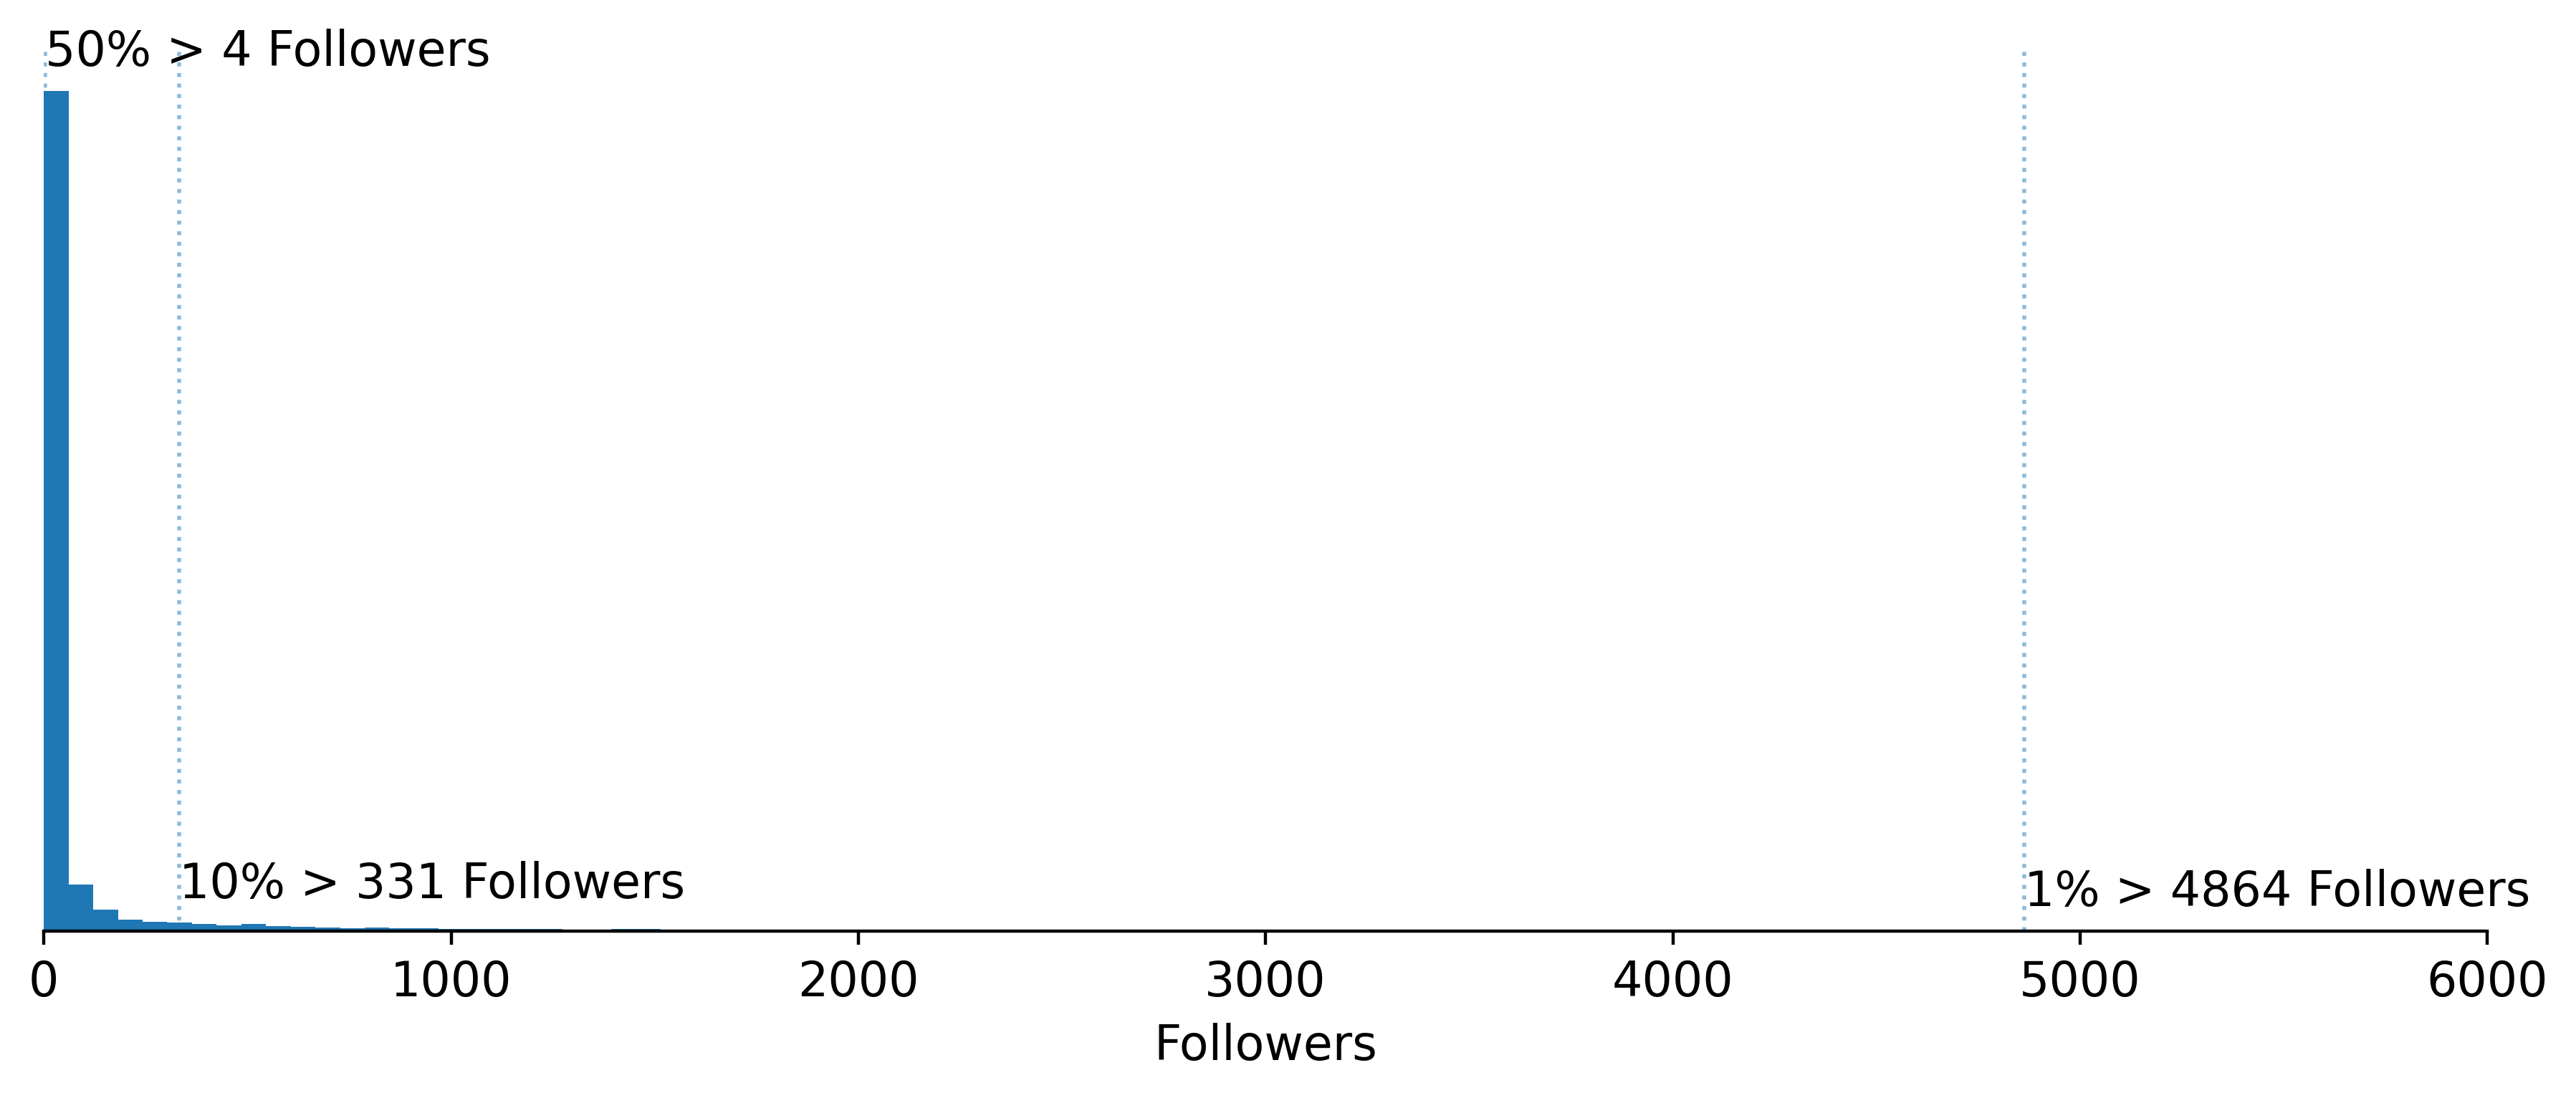

In [49]:
def plot_hist(df, ax, col, quantiles=[0.5, 0.9, 0.99], bins=50, xlim=None, qfmt="%0.0f", **kw):
    if ax is None:
        fig, ax = plt.subplots()
    if xlim is None:
        xlim = (df[col].min(), df[col].max())
    y, x, _ = ax.hist(df[col], bins=np.linspace(*xlim, bins), **kw)
    xc = 0.5 * (x[1:] + x[:-1])
    ax.set_xlim(*xlim)
    ax.set_xlabel(col)
    if quantiles:
        interp = interp1d(xc, y, bounds_error=False, fill_value=(y[0], y[-1]))
        for q, q_val in zip(quantiles, df[col].quantile(quantiles)):
            qstr = qfmt % q_val
            qy = interp(q_val) + 0.03 * y.max()
            ax.axvline(q_val, alpha=0.5, ls=":", lw=1)
            ax.annotate(f"{1-q:0.0%} > {qstr} {col}", (q_val, qy))
    ax.get_yaxis().set_visible(False) ### REMOVE
    ax.spines.right.set_visible(False) ### REMOVE
    ax.spines.top.set_visible(False) ### REMOVE
    ax.spines.left.set_visible(False) ### REMOVE
    
def plot_followers(df, ax, **kw):
    plot_hist(df, ax, "Followers", bins=100, xlim=(0, 6000), **kw)
    
plot_followers(df, None)

Let's zoom in on this distribution...

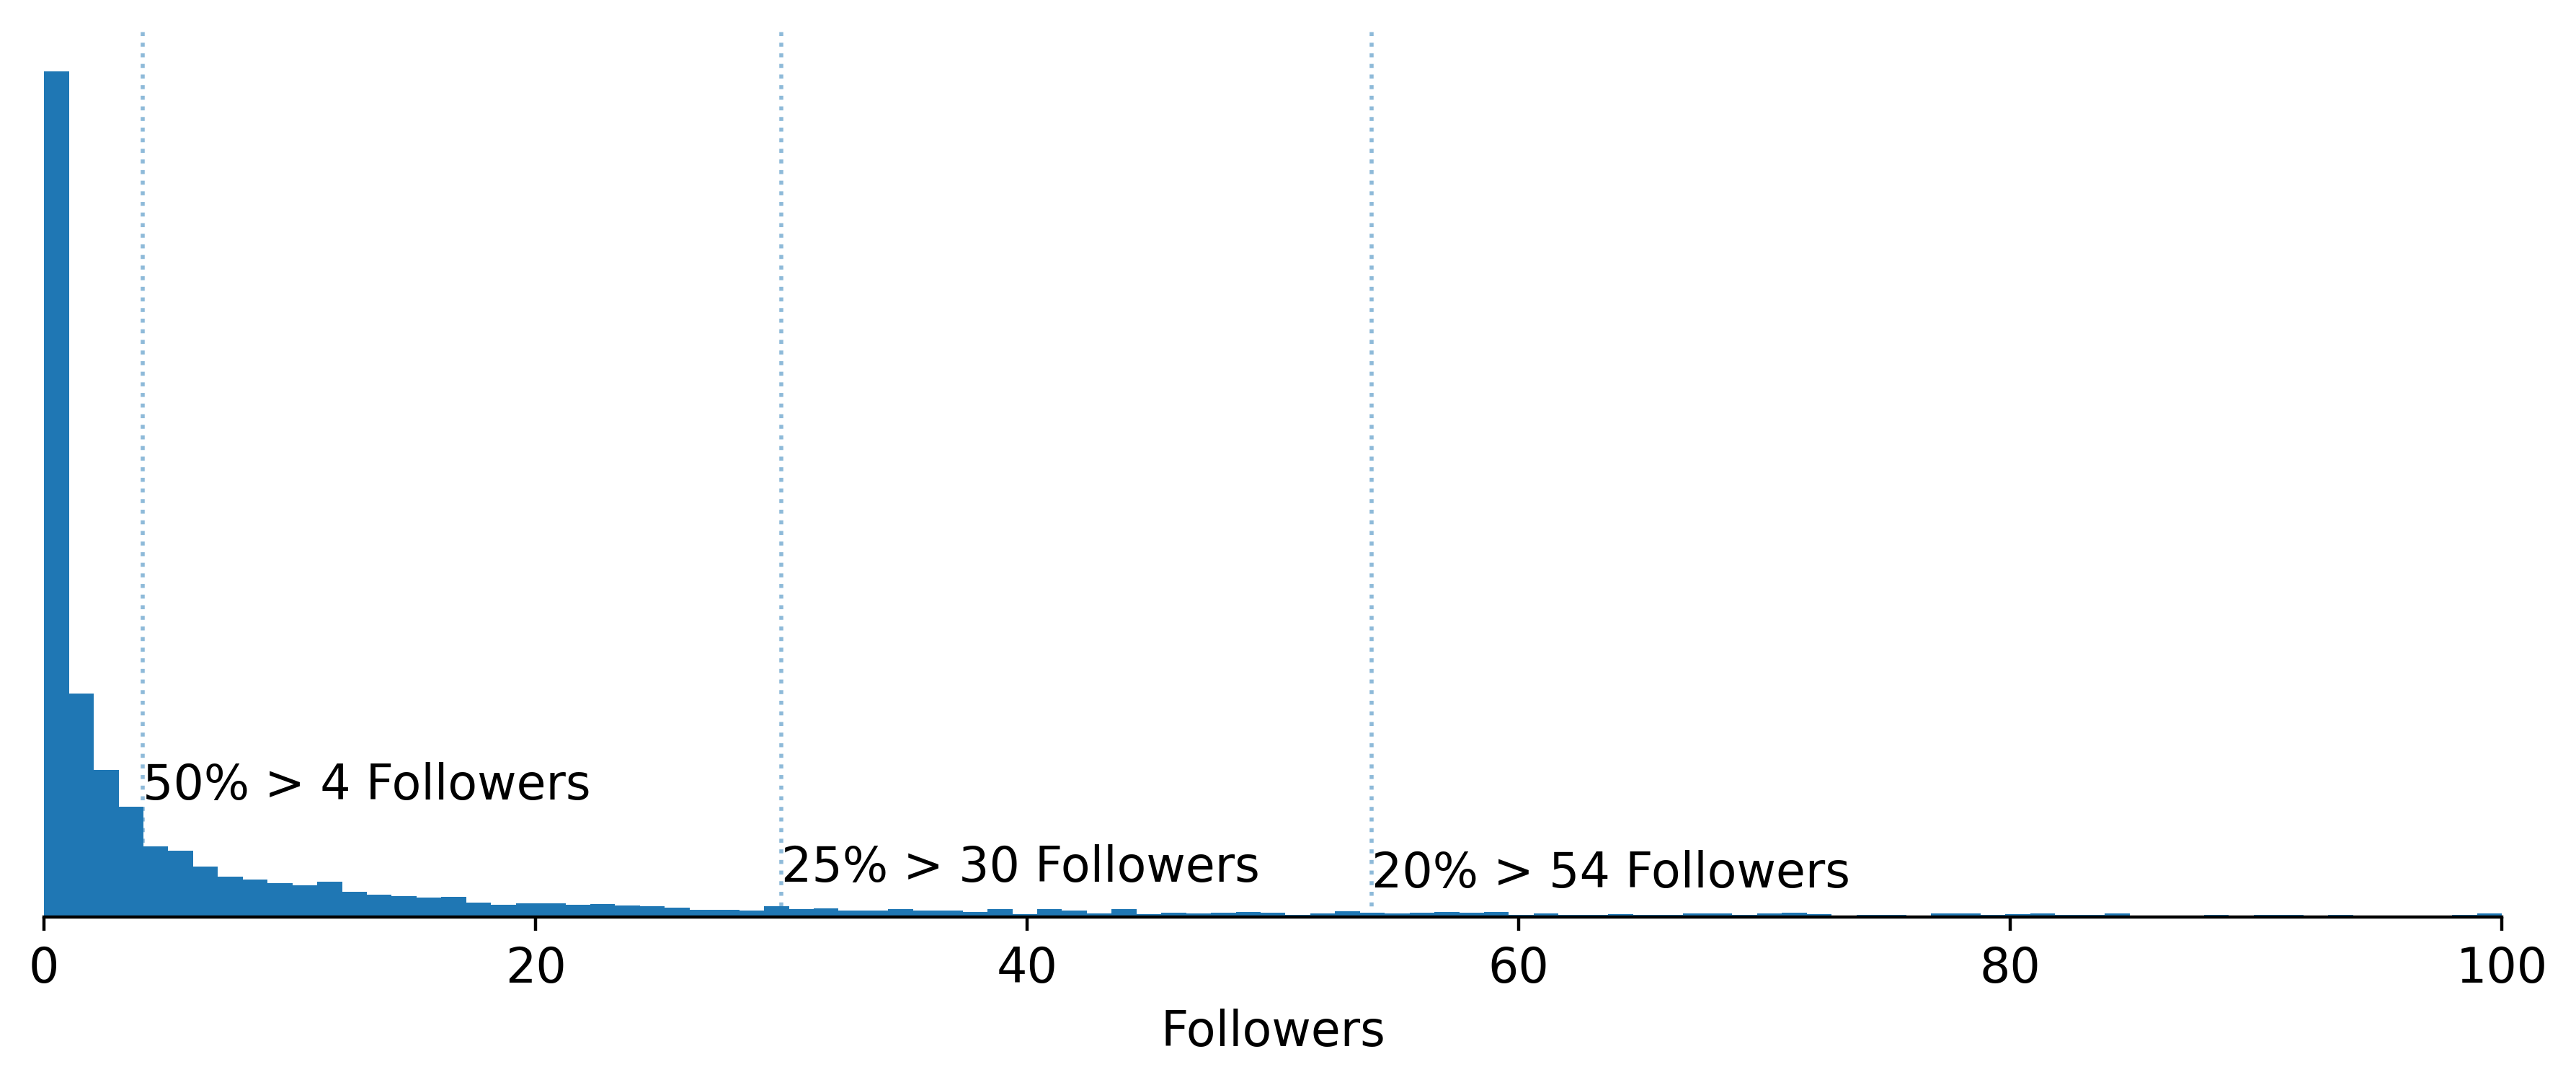

In [50]:
plot_hist(df, None, "Followers", bins=100, quantiles=[0.5, 0.75, 0.8], xlim=(0, 100))

Ouch. So the majority of serials have essentially no followers. The median number of followers is 4. If you break 330, you're in the top 10%. You'll need around 5000 for the top 1%.

In [63]:
def get_established(df: pd.DataFrame, threshold=100) -> pd.DataFrame:
    df = df[df["Followers"] > threshold].copy()
    df["Patron Value"] = df["Earnings"] / df["Patron Count"]
    df["Patron Rate"] = df["Patron Count"] / df["Followers"]
    df["Favourite Rate"] = df["Favorites"] / df["Followers"]
    df["Follow Rate (Total)"] = df["Followers"] / df["Total Views"]
    df["Follow Rate (Avg)"] = df["Followers"] / df["Average Views"]
    df["Rating Rate"] = df["Ratings"] / df["Followers"]
    return df
df_one = get_established(df, threshold=1)
df_established = get_established(df)

I'm going to filter out a lot of stories with 100 followers when making some distributions, just because we need enough followers to get some good statistics like a converged average rating.

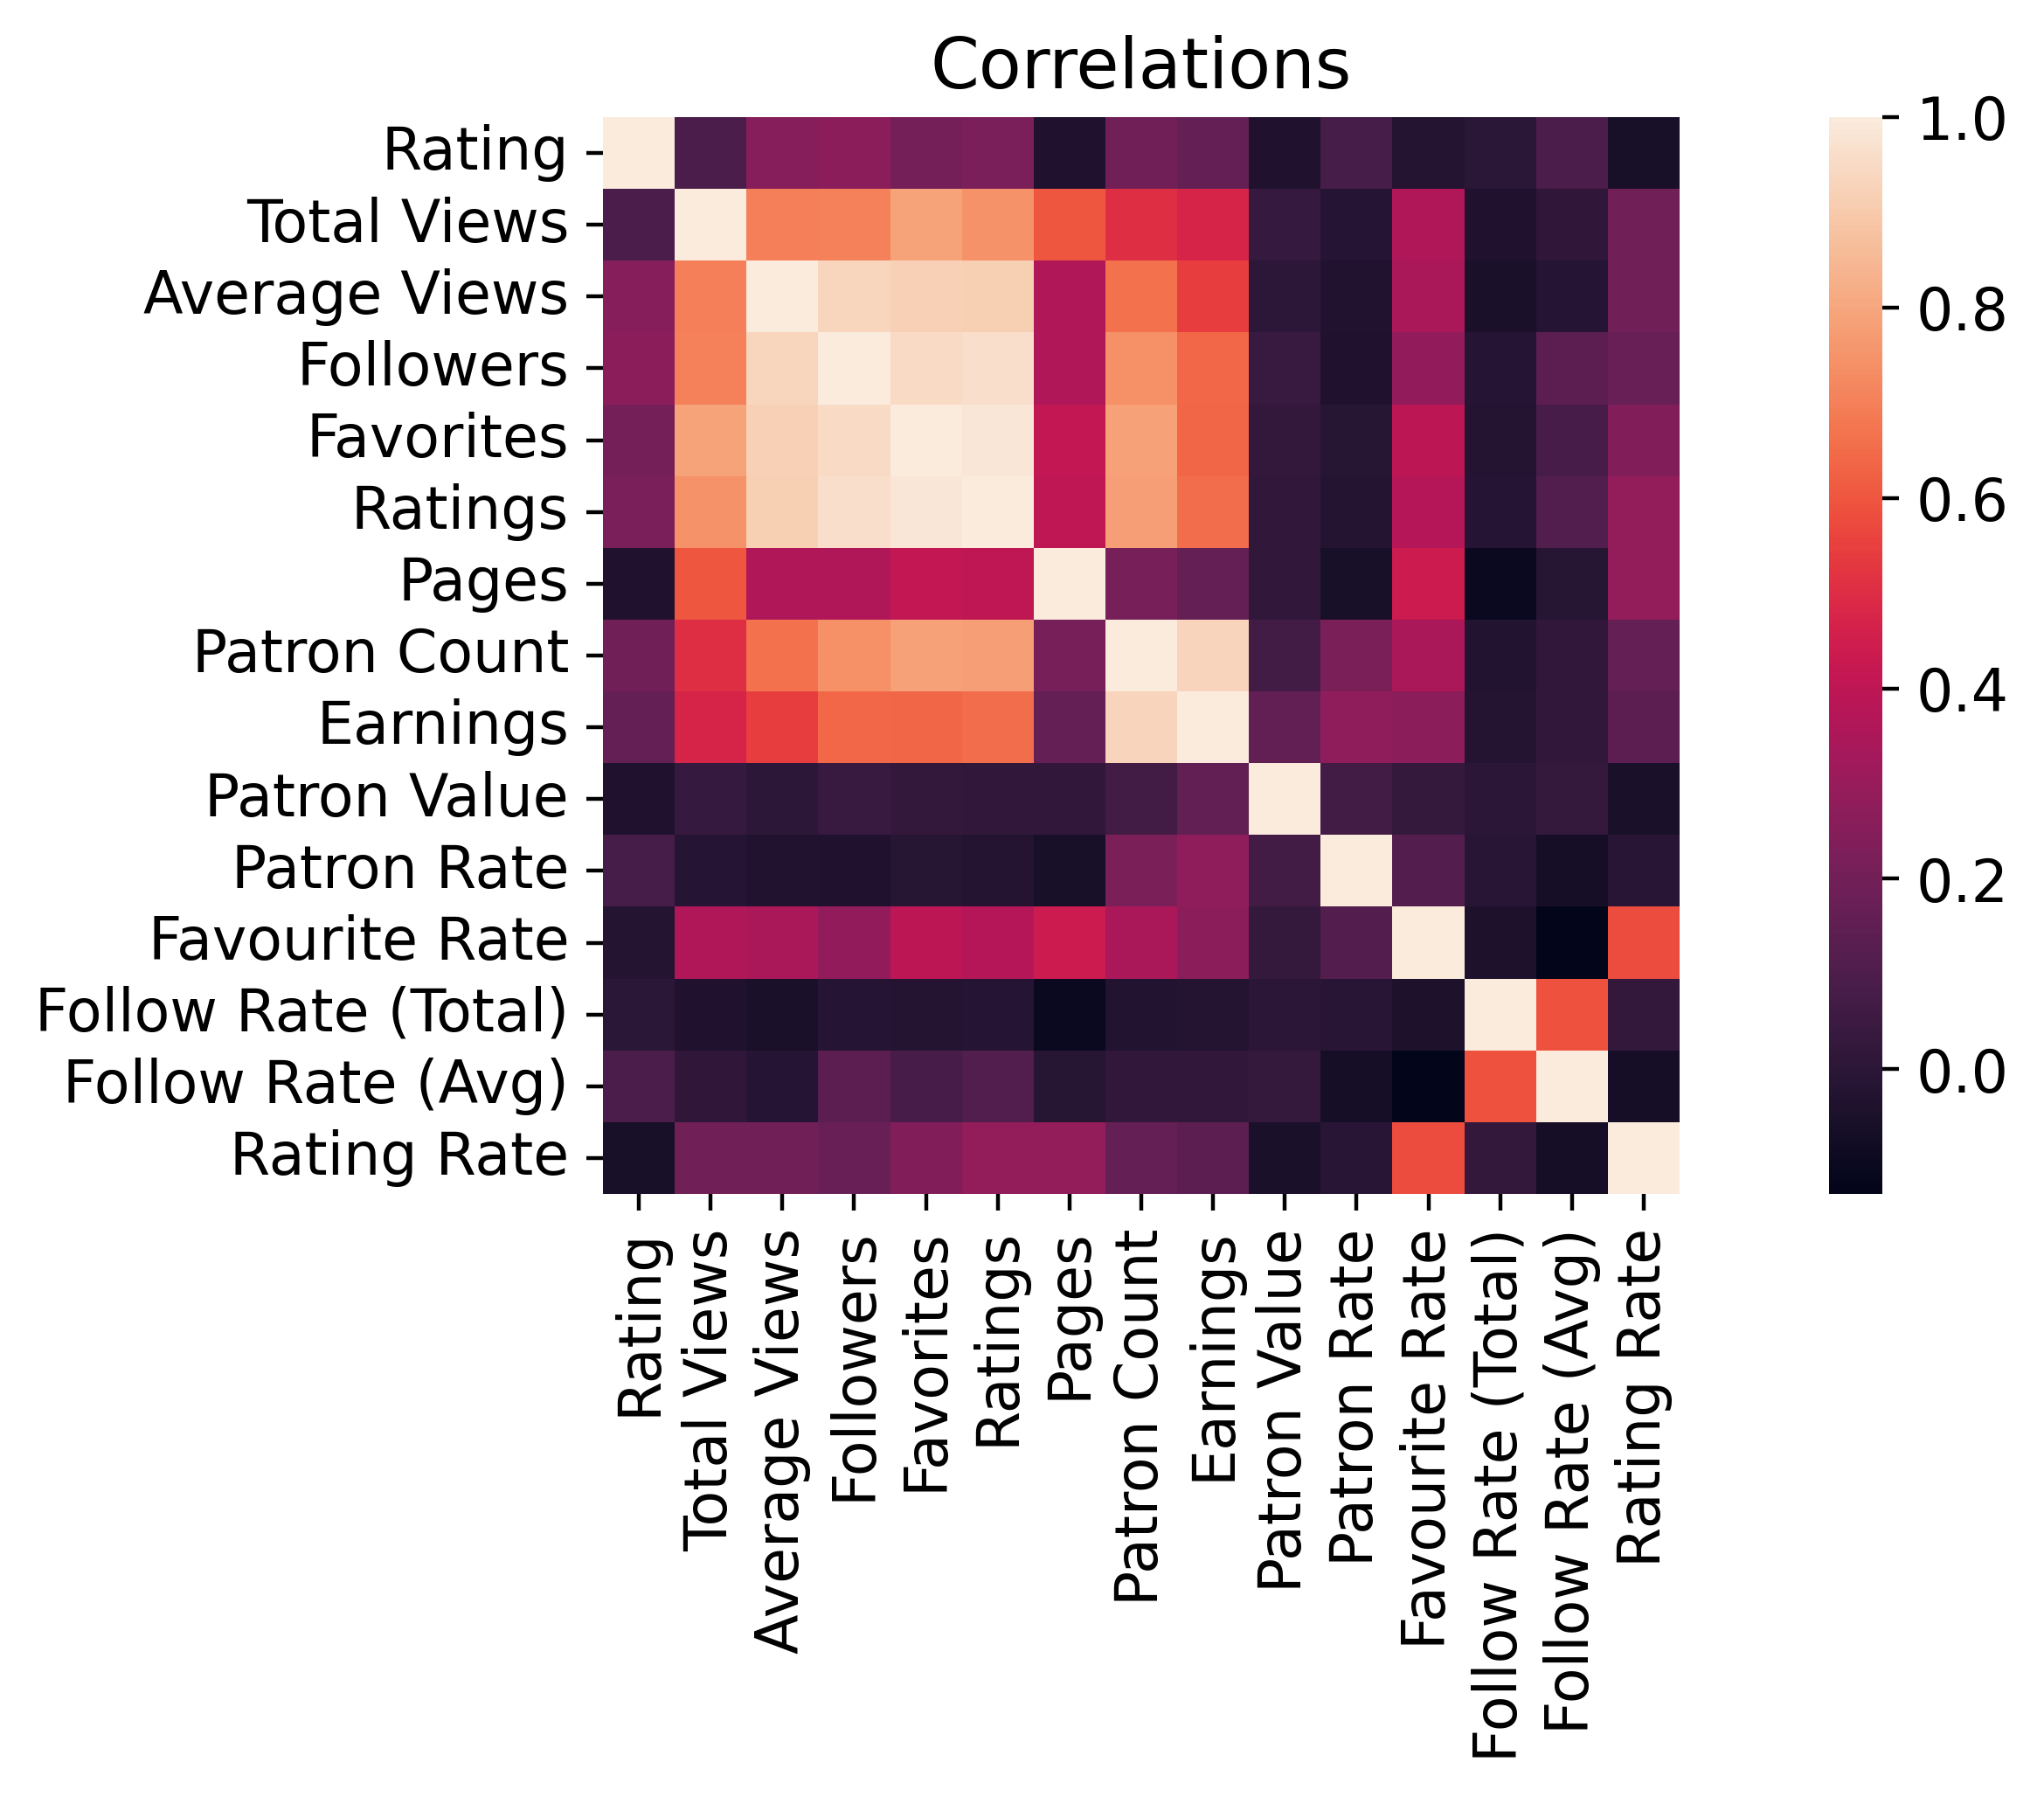

In [64]:
# Use correlation to show pages and rating are the weakest indicators of Followers
def plot_cor(df, ax):
    cor = df.corr(numeric_only=True)
    sb.heatmap(cor, ax=ax, square=True)
    ax.set_title("Correlations")
    
fig, ax = plt.subplots()
plot_cor(df_established, ax)

Obviously we expect most of these correlations. The more views you have, the more followers, means the more favourites, and the more ratings. And the more patrons, the higher your earnings, of course. Interestingly, page count does very little, along with Rating. So those aren't significant barriers to entry, rejoice those who have been review bombed!

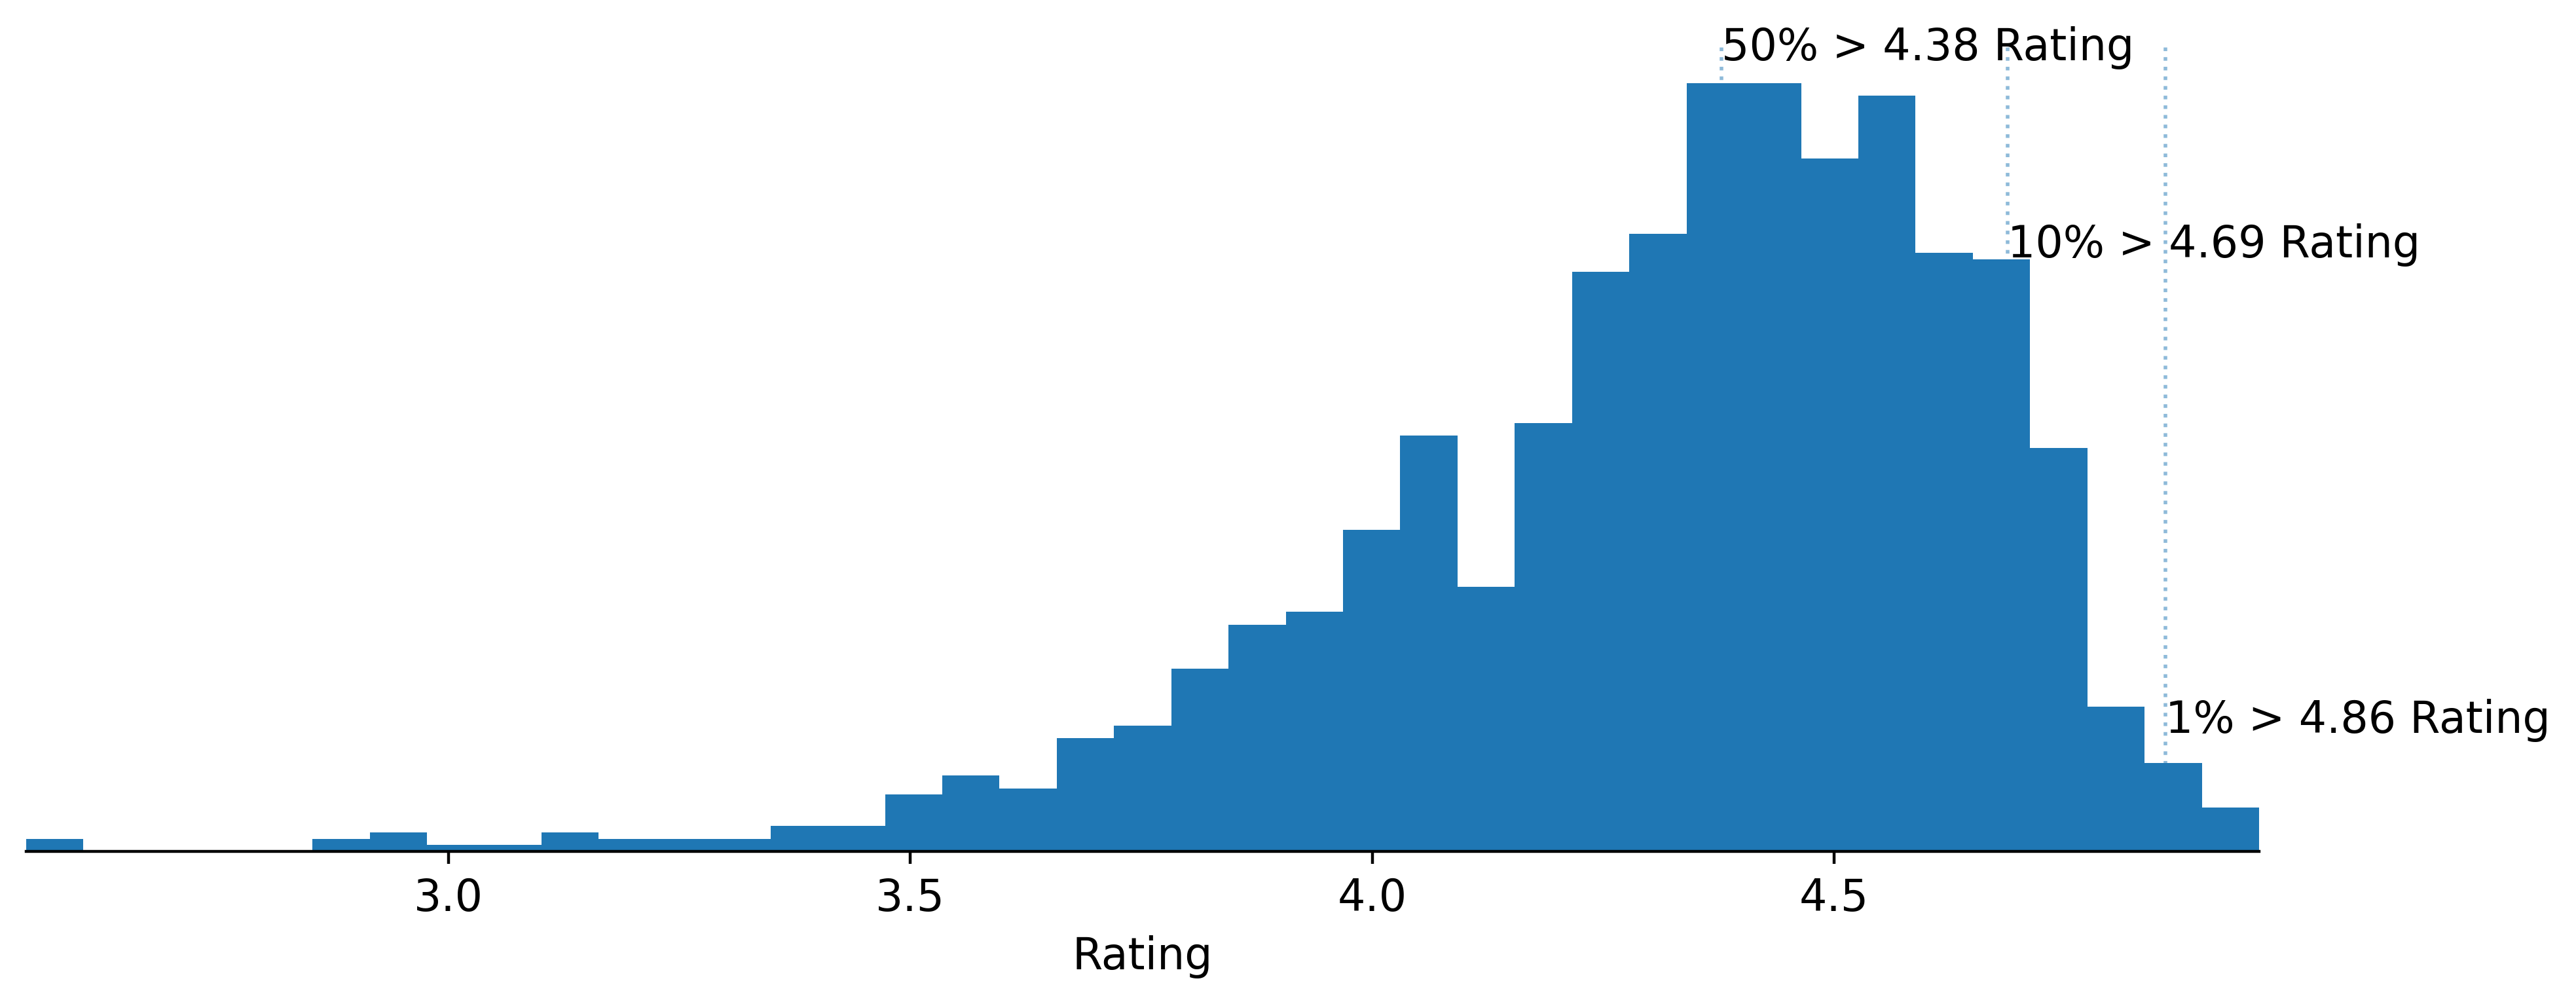

In [65]:
# Look into avergae profit per patreon
def plot_ratings(df, ax):
    plot_hist(df, ax, "Rating", qfmt="%0.2f", bins=40)

plot_ratings(df_established, None)

The standard 4.5 stars distribution seen everywhere with a 5 star rating system.

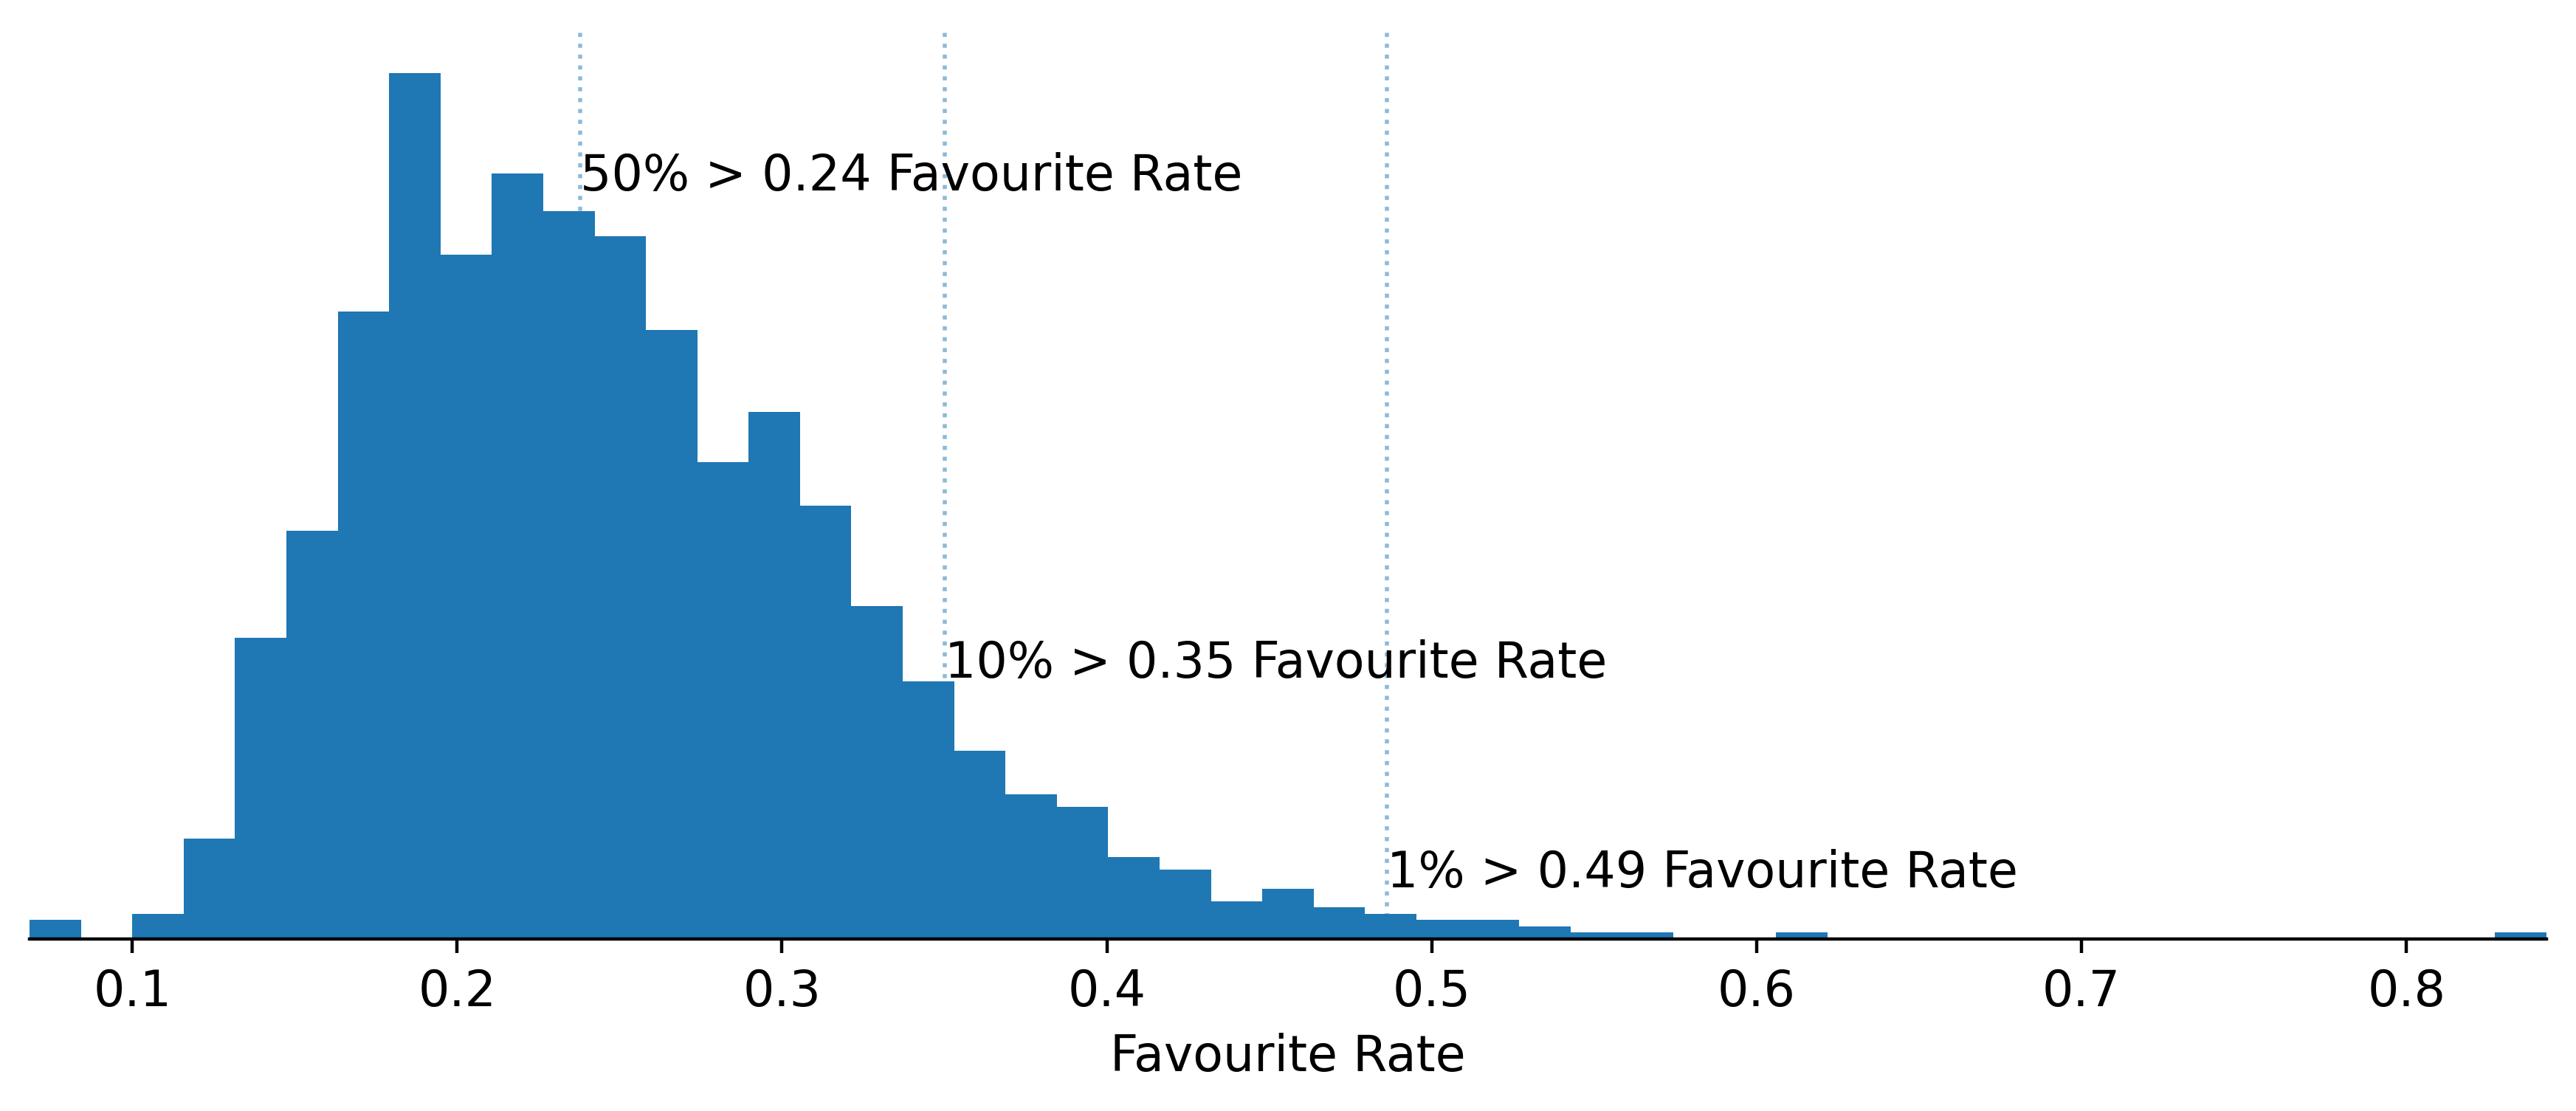

In [66]:
plot_hist(df_established, None, "Favourite Rate", qfmt="%0.2f")

So for every 100 followers, the median story gains 24 favourites.

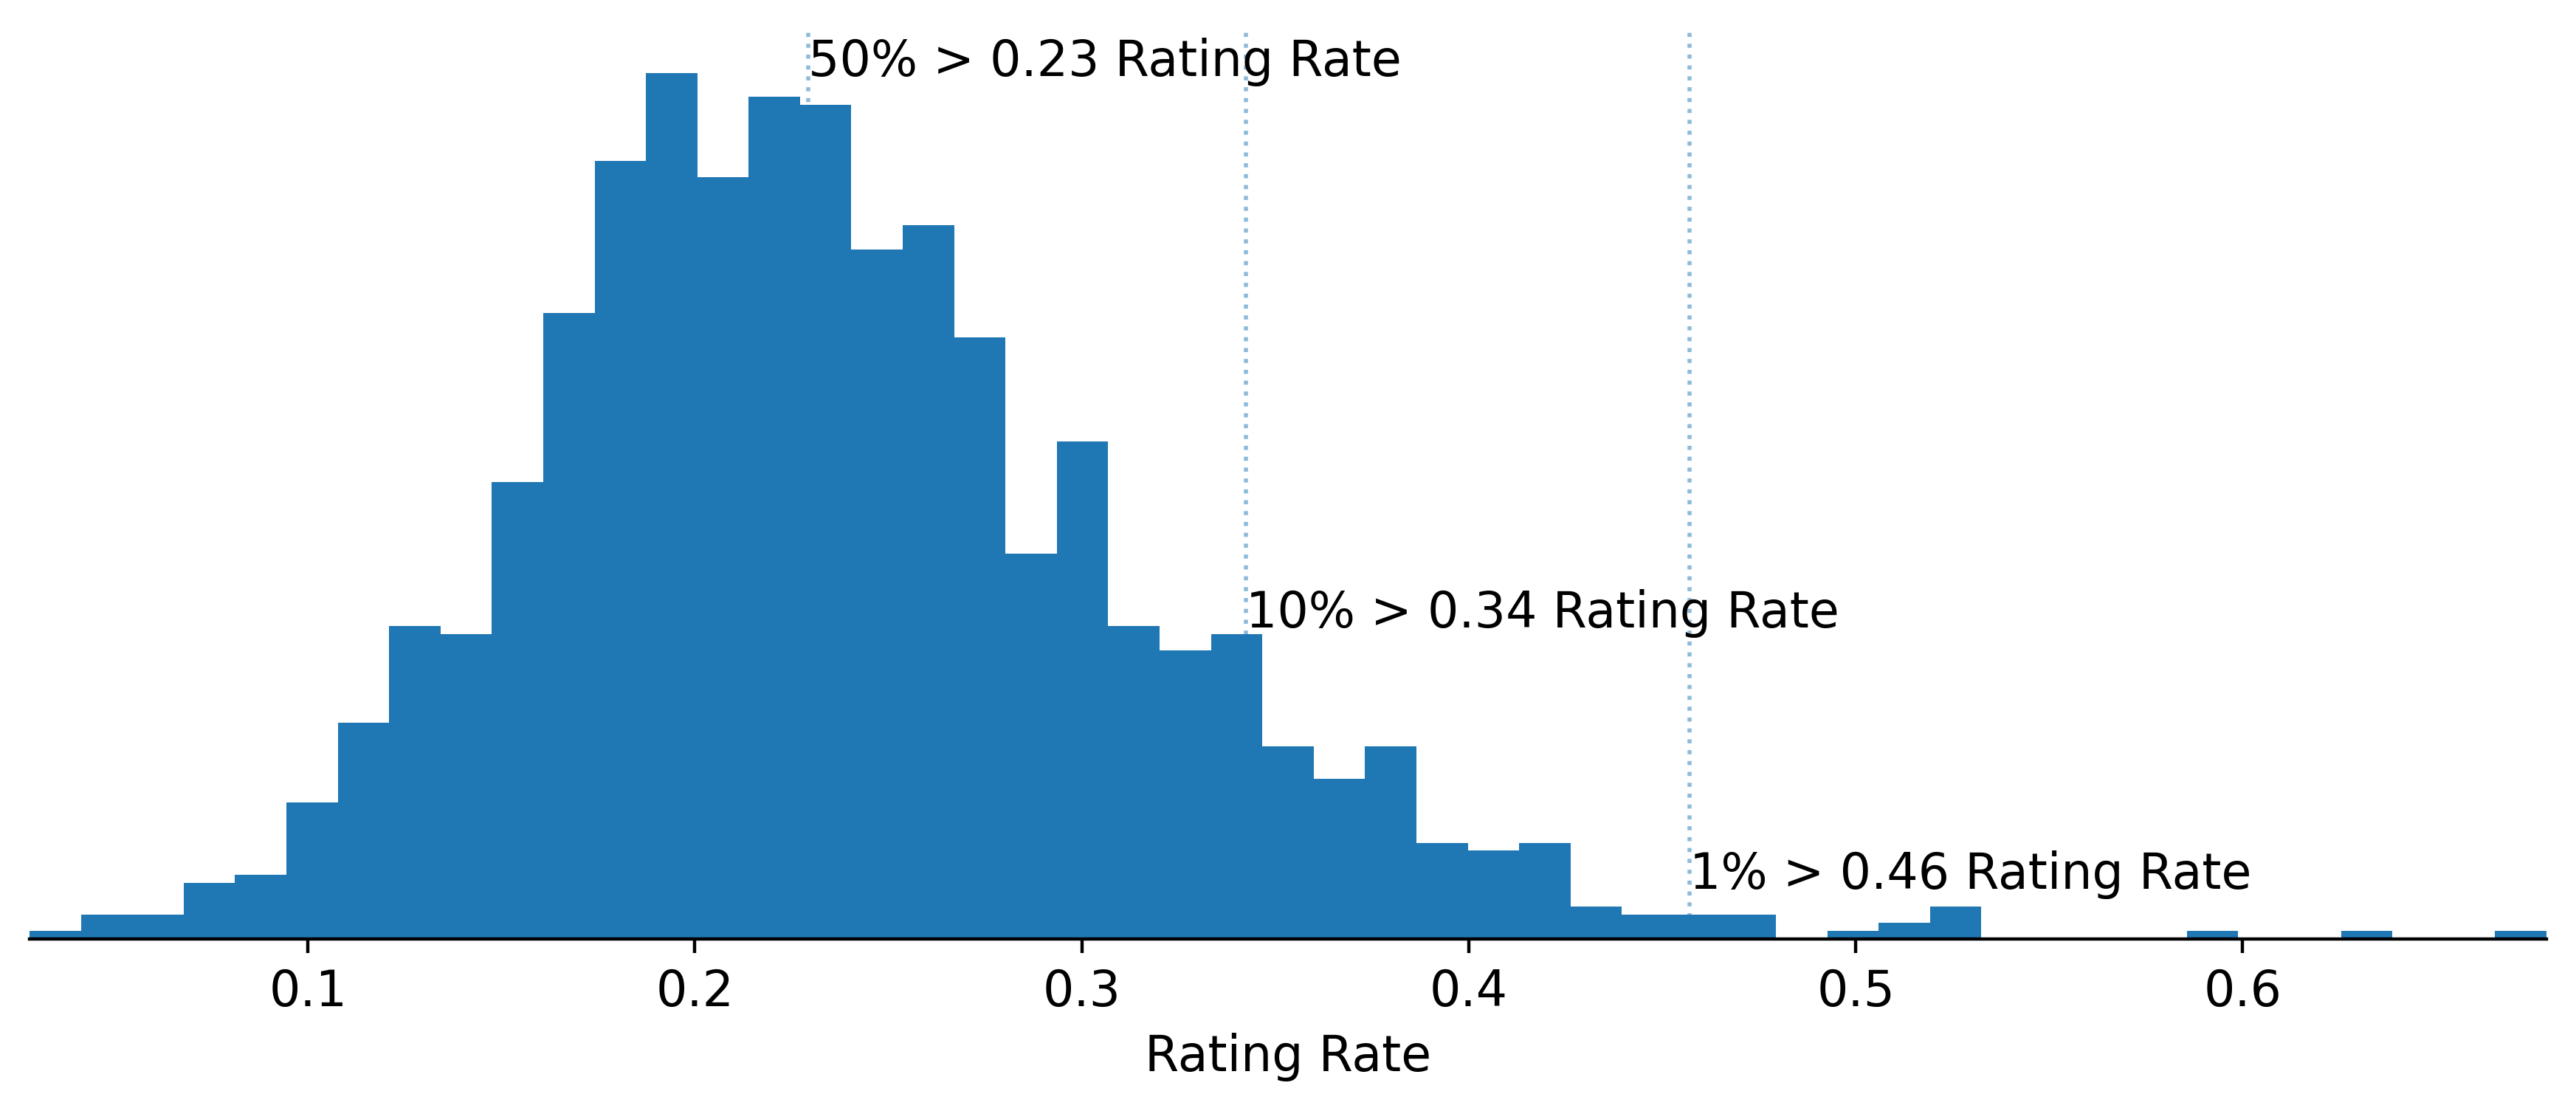

In [67]:
plot_hist(df_established, None, "Rating Rate", qfmt="%0.2f")

Looks like a similar story for the ratings. Median conversion of 23% from follow to a rating.

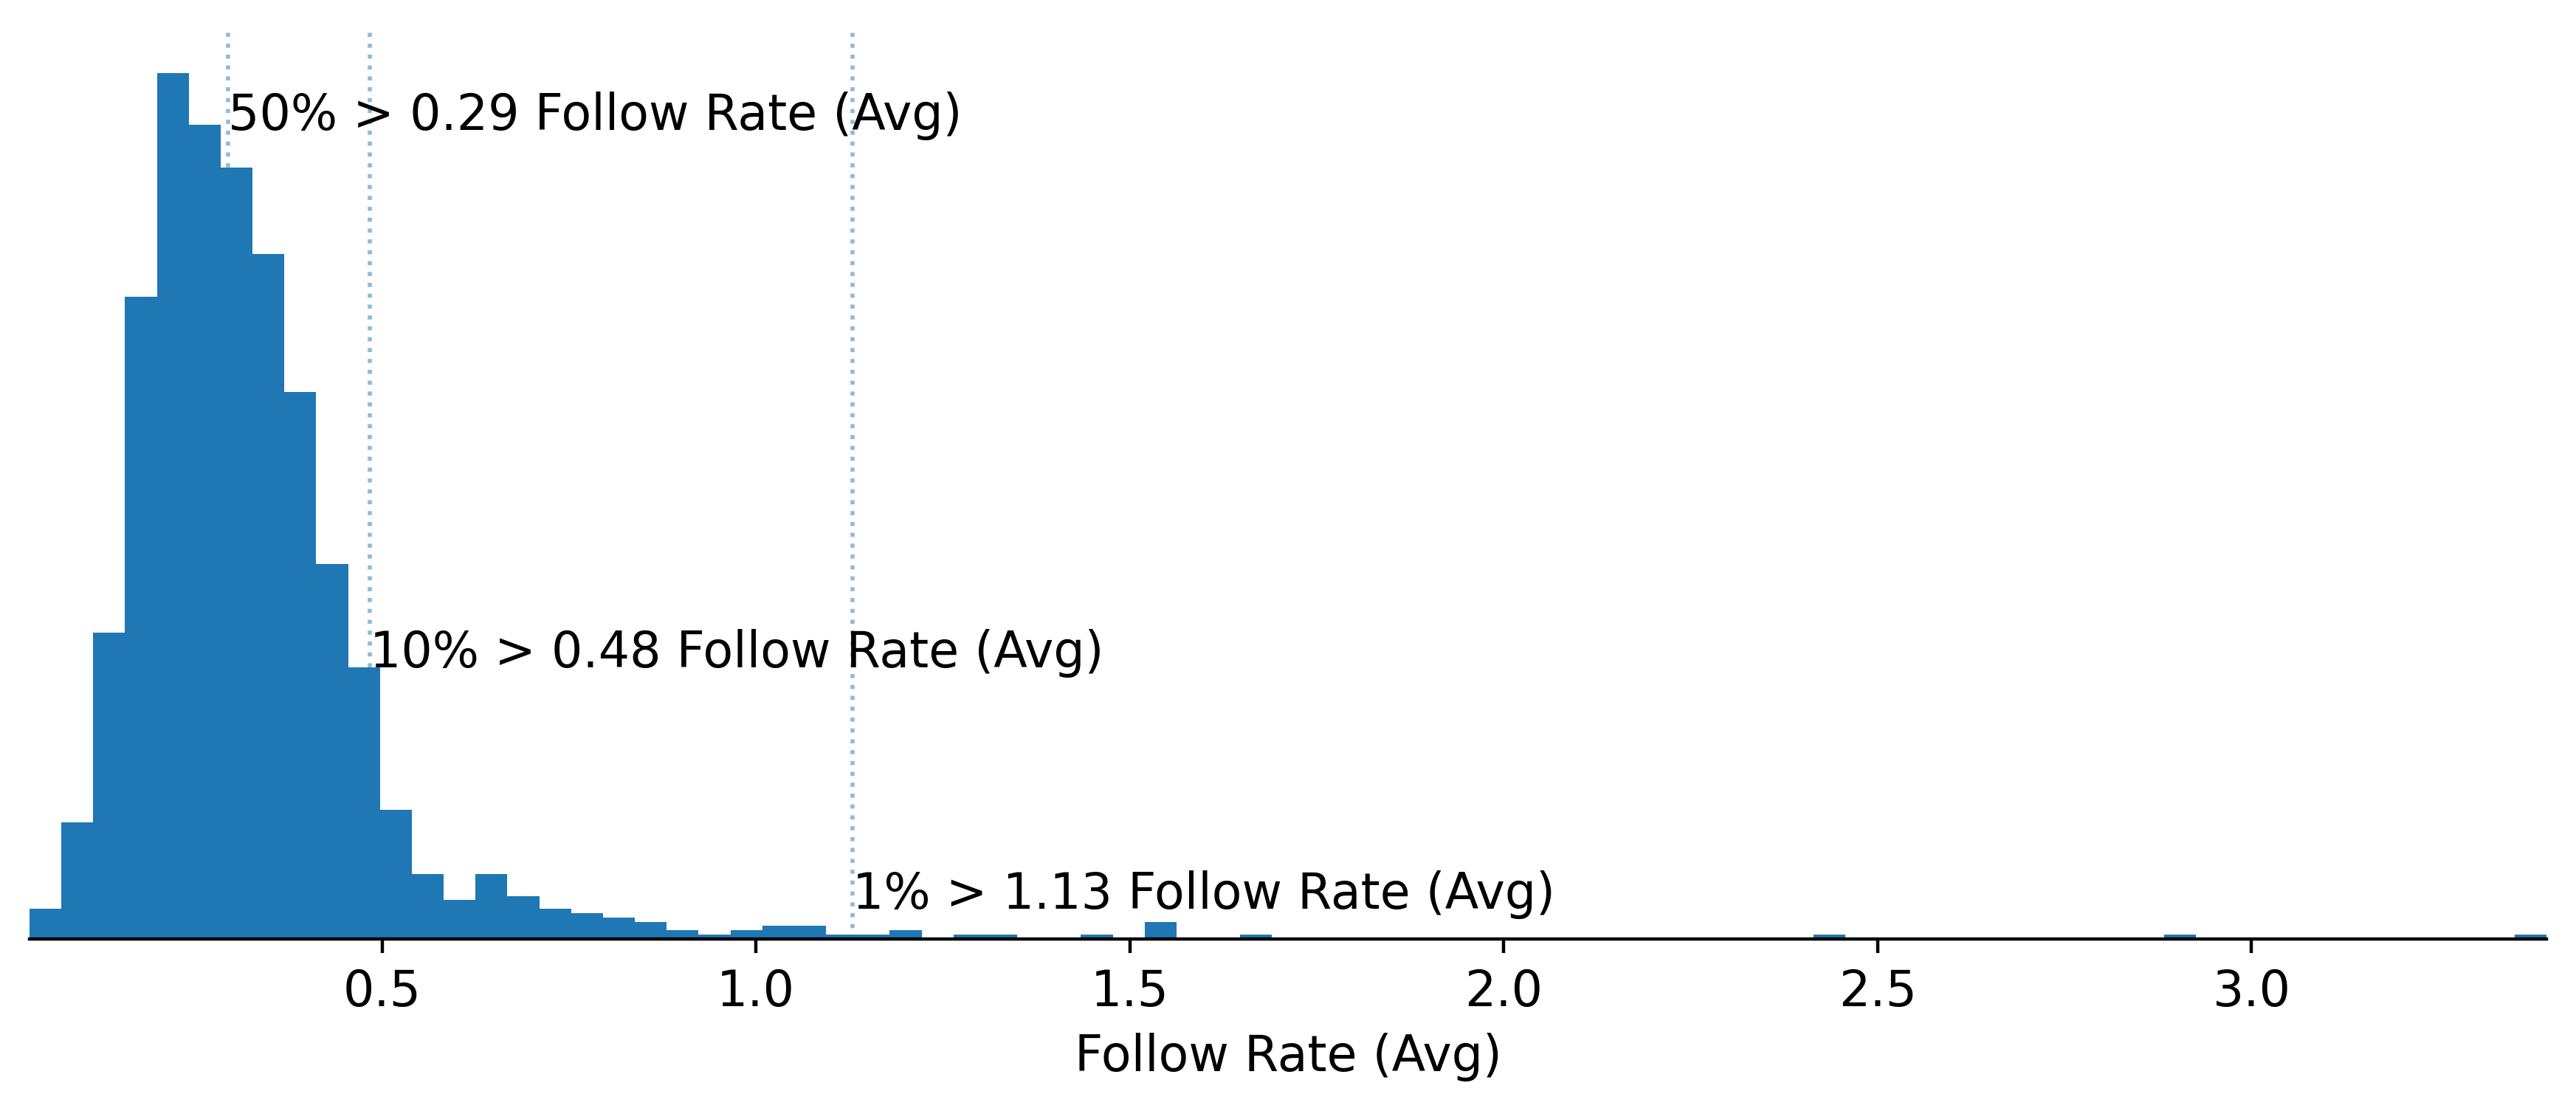

In [68]:
plot_hist(df_established, None, "Follow Rate (Avg)", qfmt="%0.2f", bins=80)

This is a bit harder to interpet, because I don't believe RR is giving us a total number of unique visitors (indeed its hard to determine that number without browser fingerprinting anyway). So instead we have the average views per chapter, and I'm curious how this translates into the number of followers. Note, I don't have the average number of followers *per* chapter, which would be a much better bit of data. So the plot above, in my mind, is almost useless. But what it does (maybe) show is that if an author gets 10k views per chapter, the median would have that translate into a story with 2.9k followers. 

I also expect the above to be highly dependent on hiatus and gaps in the story, but again, don't have the data. Frustrated there's no official API.

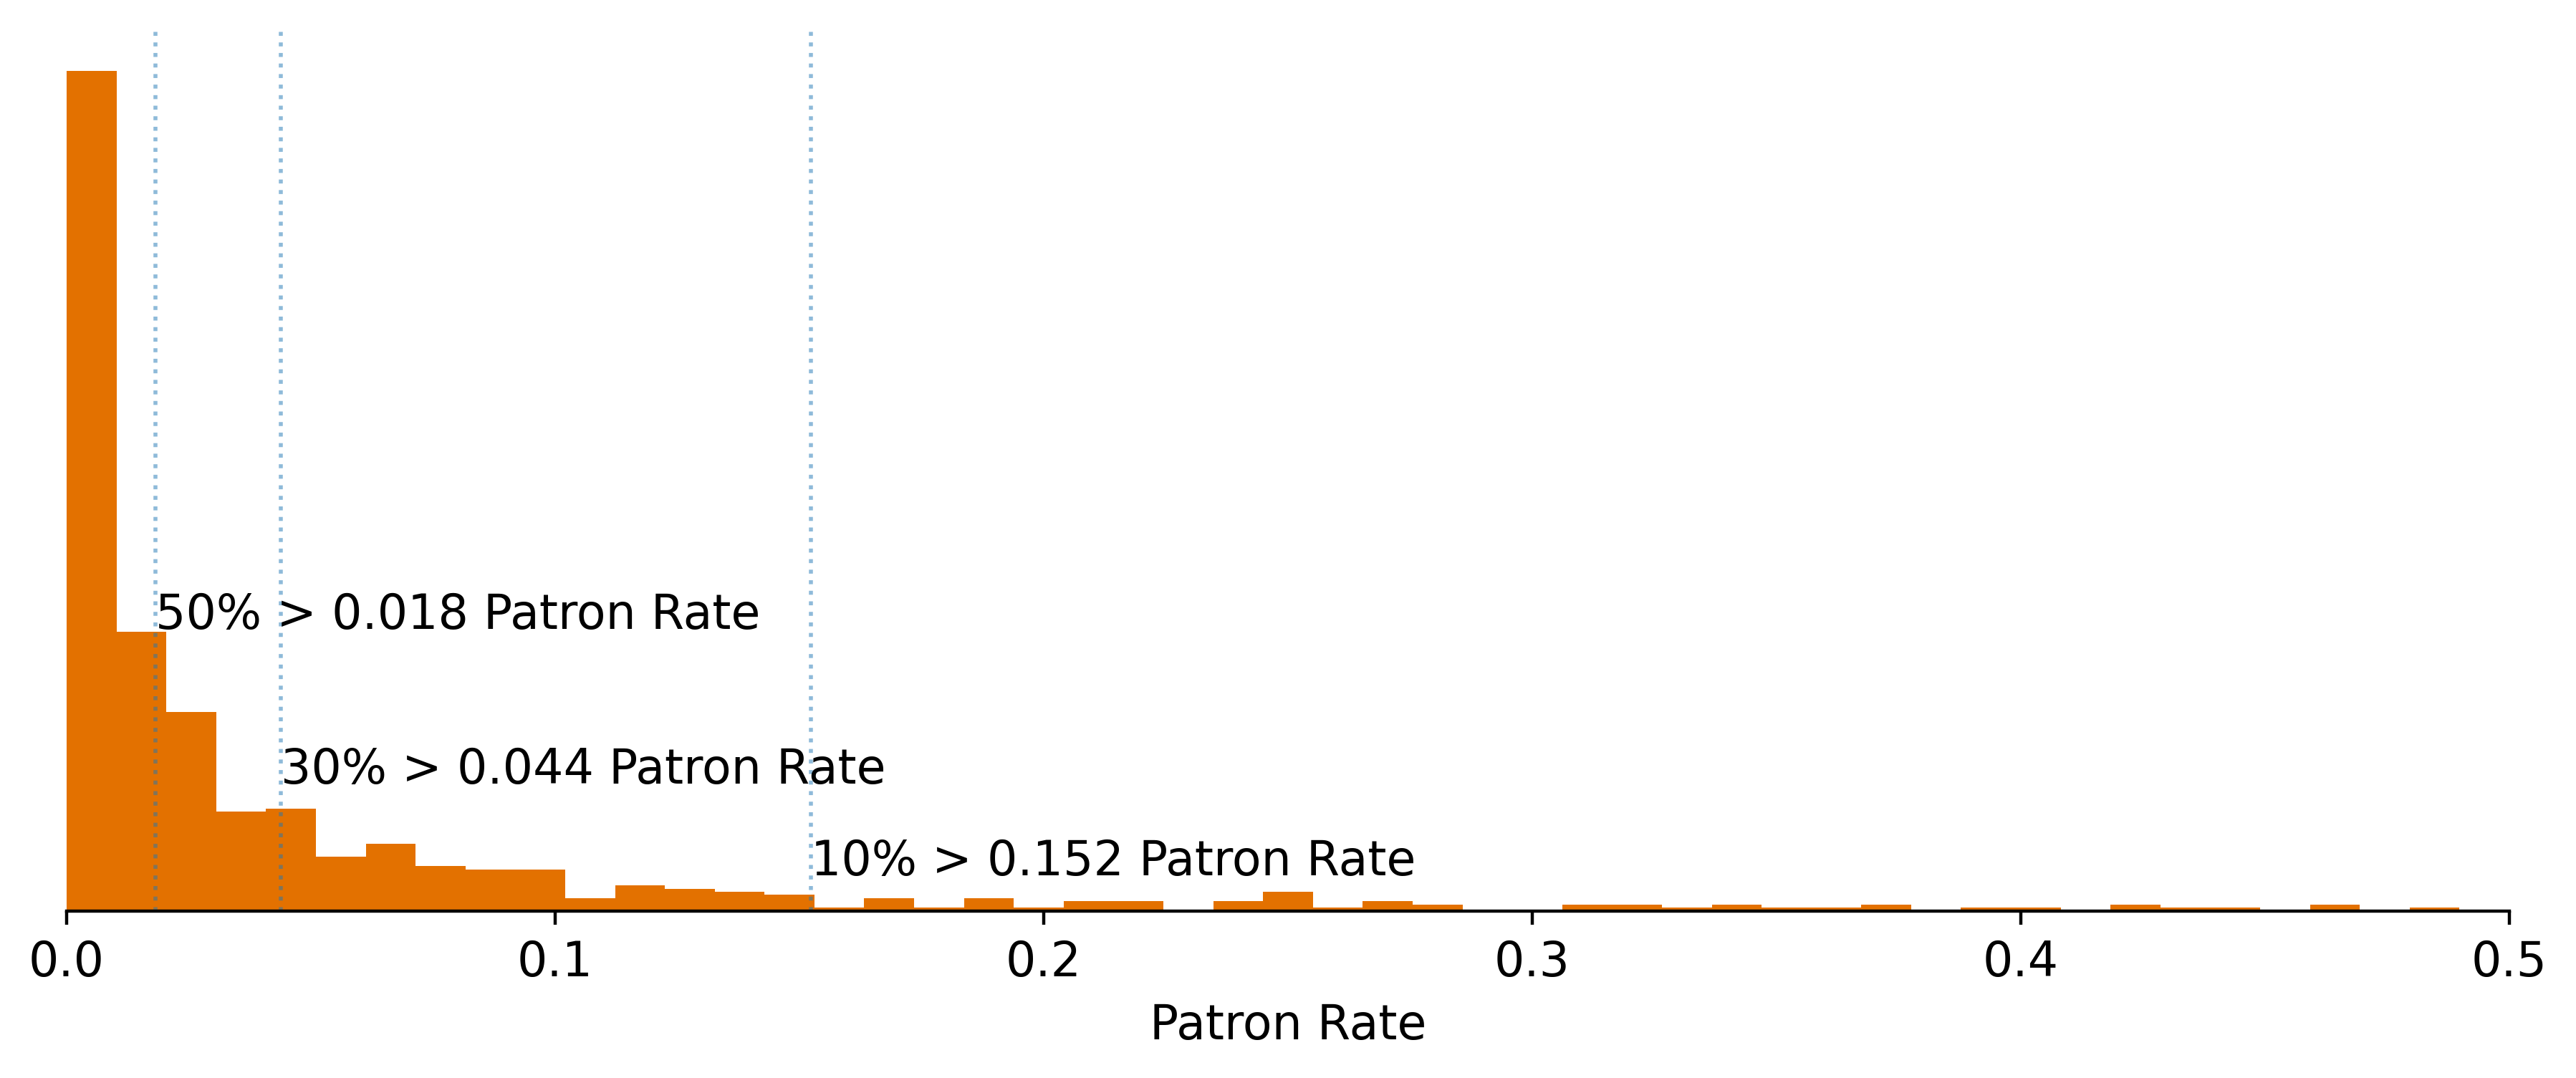

In [75]:
# Covnersion between Followers/Favourites to Patreon count'
pcolor = "#e37100"
def plot_prate(df, ax):
    # Have to group authors with multiple stories leading to same patreon
    df2 = df.groupby("Patreon Link").sum(numeric_only=True).reset_index()
    df2 = df2[df2["Patron Rate"] < 1.0].copy()
    plot_hist(df2, ax, "Patron Rate", qfmt="%0.3f", color=pcolor, xlim=(0, 0.5), quantiles=[0.5, 0.7, 0.9])

plot_prate(df_established, None)

The higher conversion rate numbers might be unreliable. This assumes that the RR stories I've found are the only funnels into Patreon, and this might not be correct, especially for stories which are also released in other locations.

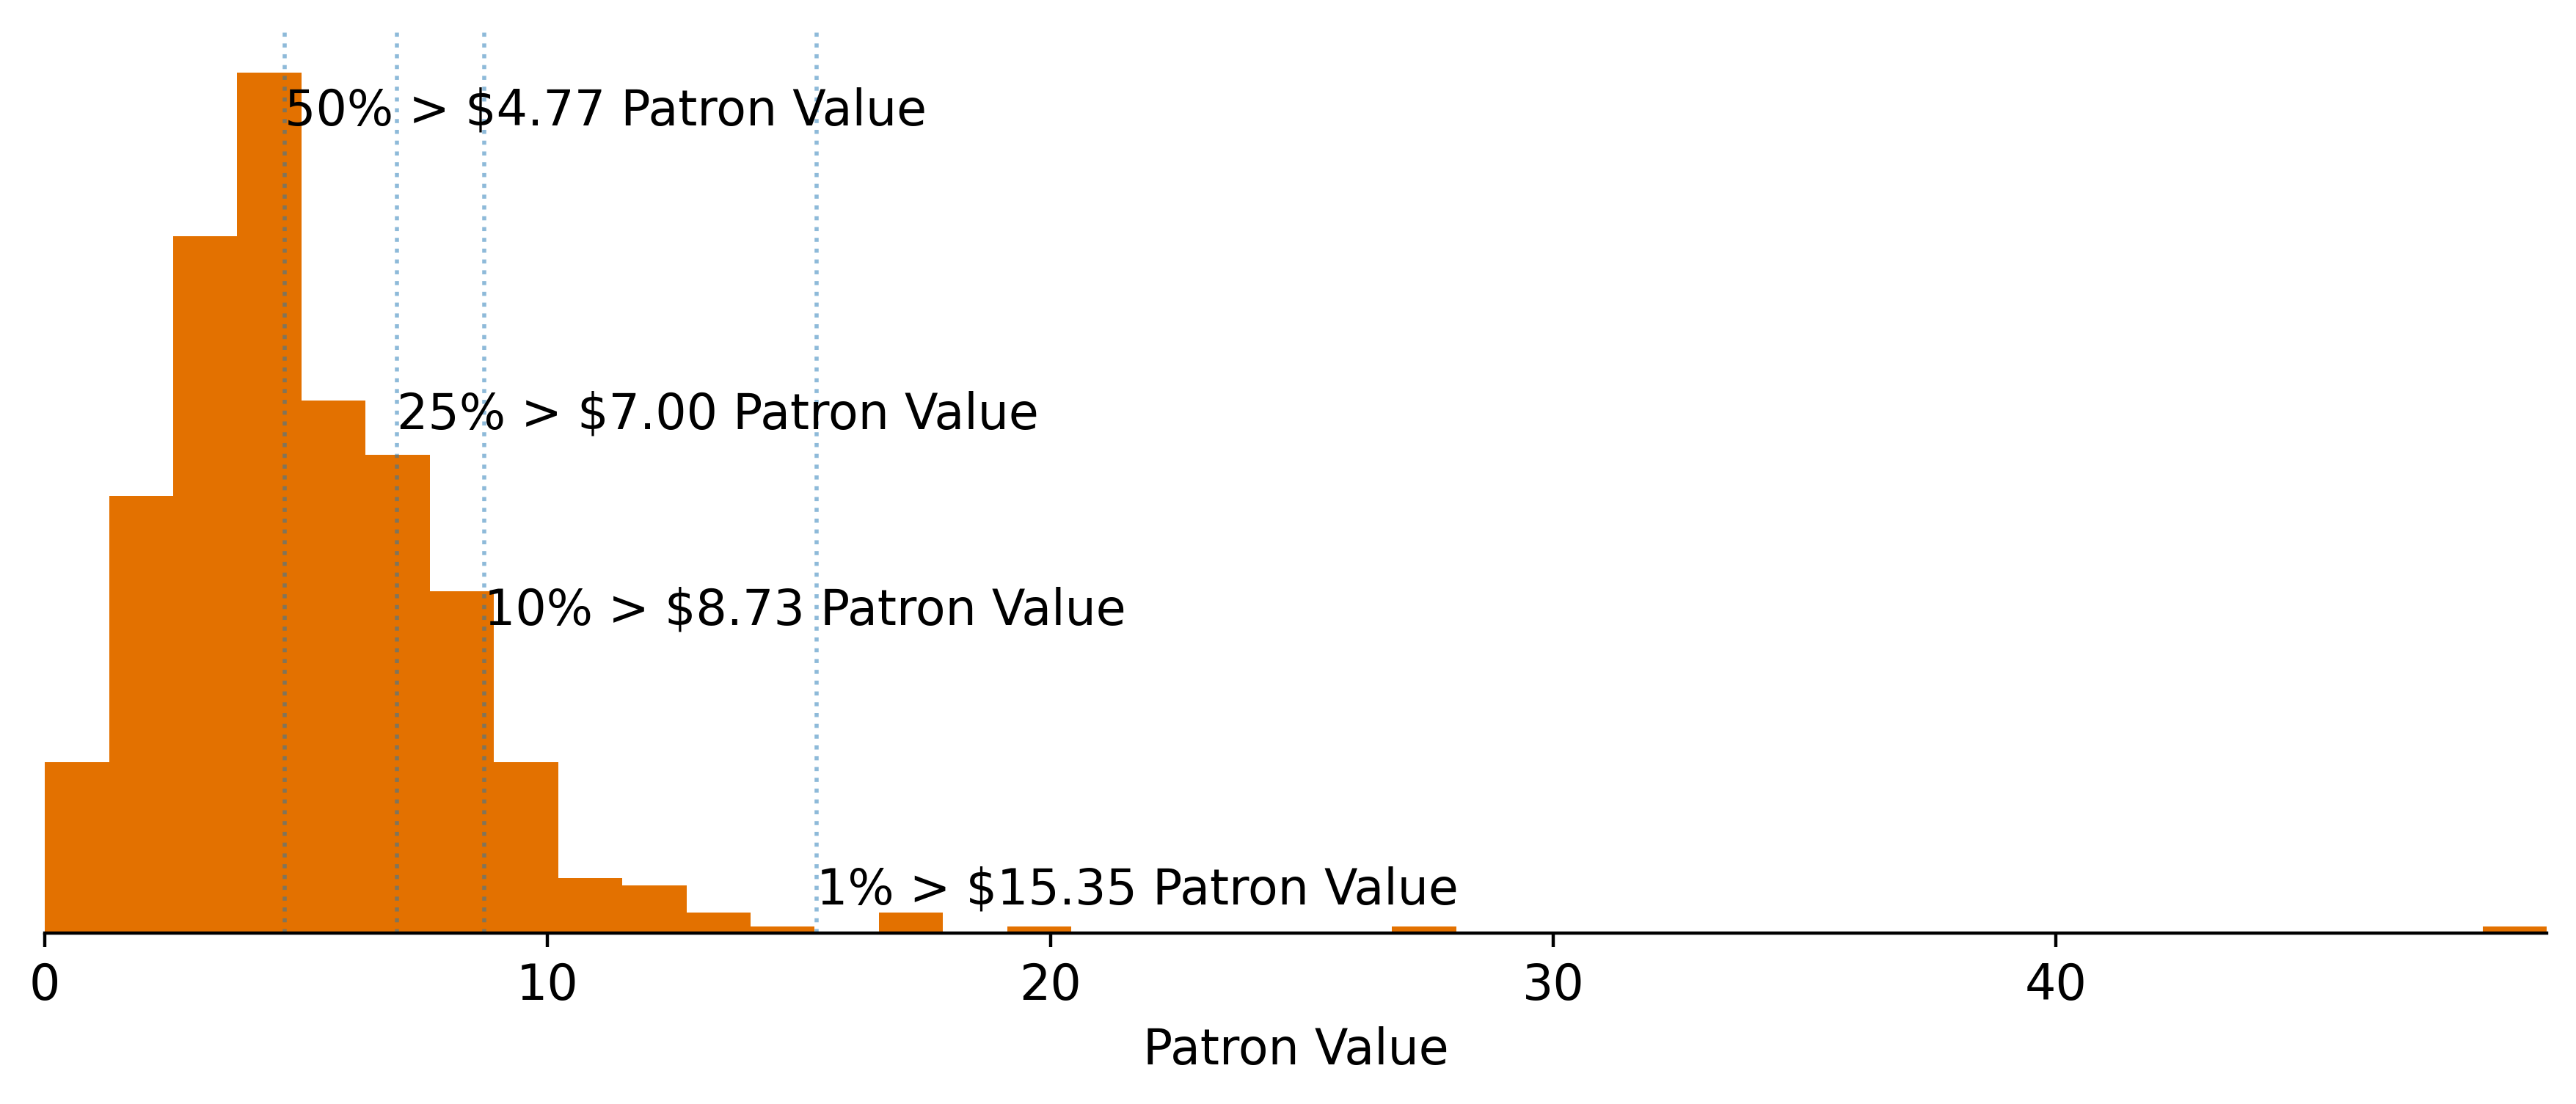

In [70]:
# Curious about the average value of each patron
def plot_pvalue(df, ax):
    plot_hist(df, ax, "Patron Value", qfmt="$%0.2f", bins=40, quantiles=[0.5, 0.75, 0.9, 0.99], color=pcolor)

plot_pvalue(df_established, None)

As a caveat, not all patreons have their income public, so this is only using that subset where we have both income and number of patrons.

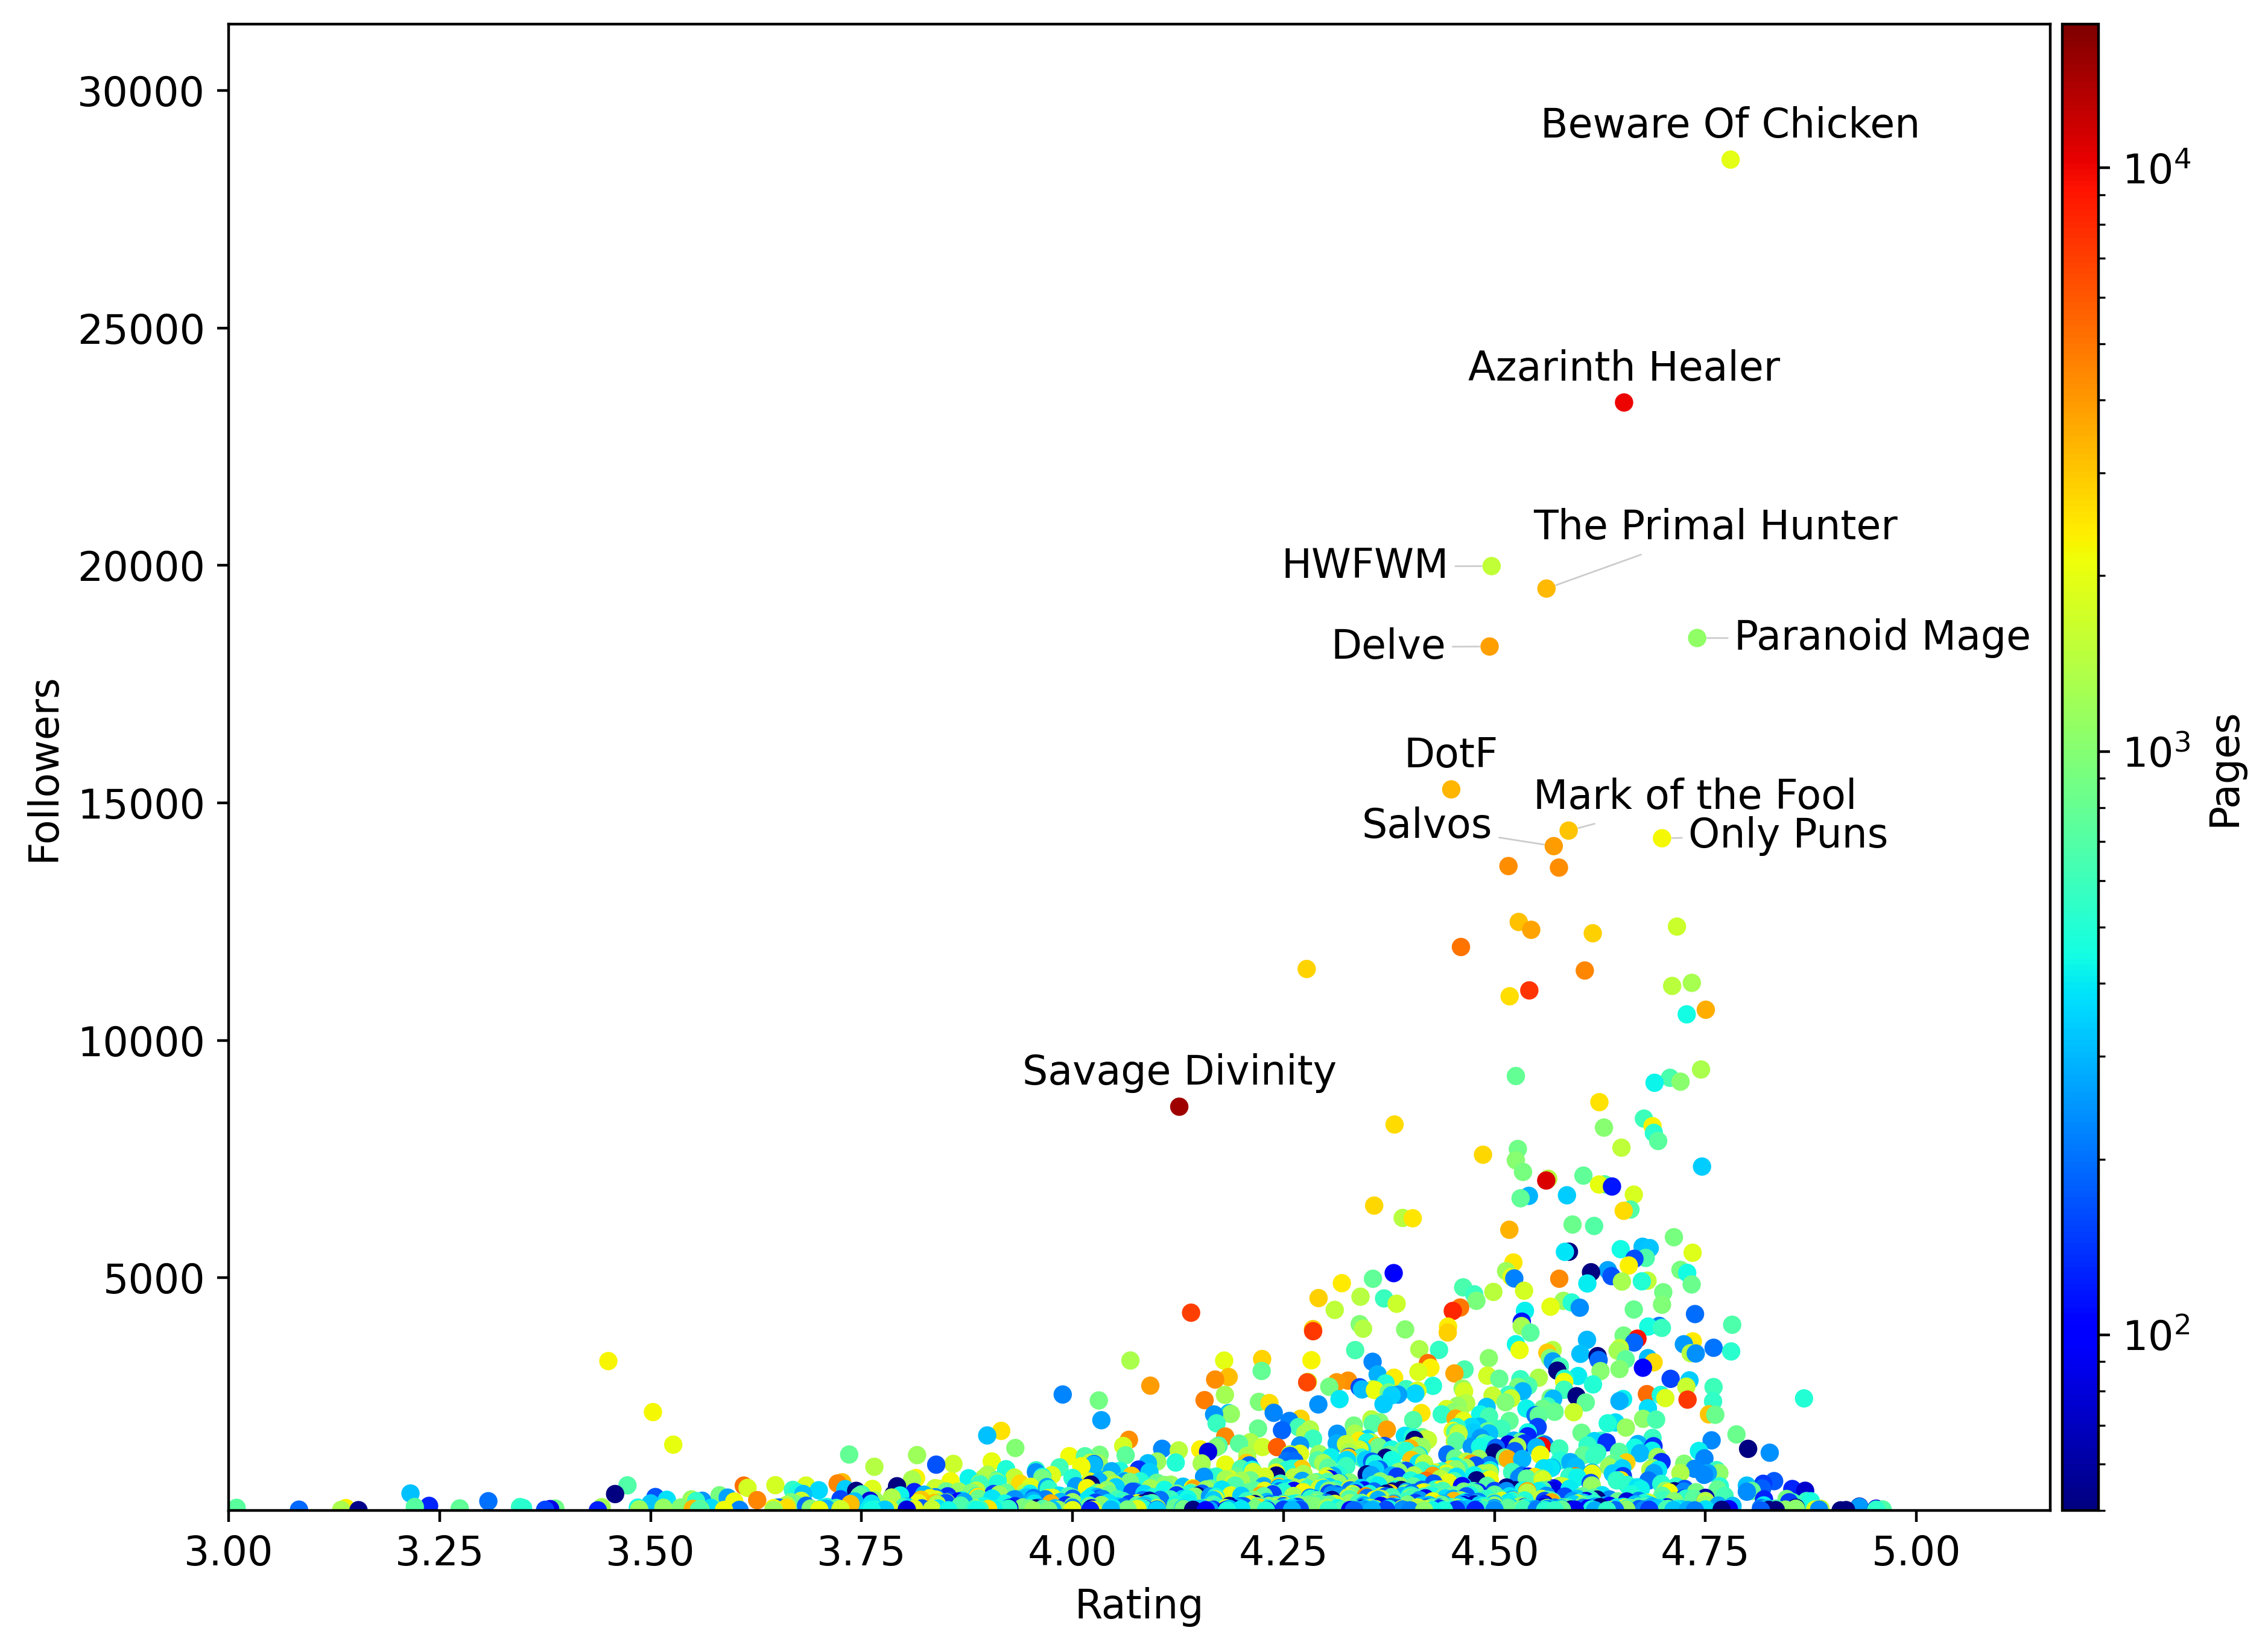

In [71]:
#Create overview plot
def plot_overview(df, ax, fig):
    x = df["Rating"]
    y = df["Followers"]
    c = df["Pages"]
    s = 20
    h = ax.scatter(x, y, c=c, s=s, cmap="jet", norm=matplotlib.colors.LogNorm(vmin=50, vmax=c.max() * 1.2),)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    fig.colorbar(h, cax=cax, orientation='vertical', label="Pages")
    ax.set_xlim(3, x.max() * 1.04)
    ax.set_ylim(y.min(), 1.1 * y.max())
    ax.set_xlabel("Rating")
    ax.set_ylabel("Followers")
    
    padding = y.max() * 0.01
    replace = {
        "He Who Fights With Monsters": "HWFWM",
        "Salvos (A Monster Evolution LitRPG)": "Salvos",
        "Defiance of the Fall": "DotF",
        "There is no Epic Loot here, Only Puns.": "Only Puns"
    }
    offset = {
        "HWFWM": (-0.15, -1.5),
        "The Primal Hunter": (0.2, 3),
        "Paranoid Mage": (0.22, -1.5),
        "Delve": (-0.12, -1.5),
        "Mark of the Fool": (0.15, 1),
        "Salvos": (-0.15, 0),
        "Only Puns": (0.15, -1.3),
    }
    def annotate(i, row):
        t = replace.get(row['Title'], row['Title'])
        o = offset.get(t, (0,1))
        pos = x[i], y[i]
        arrow = dict(arrowstyle="-", alpha=0.2, lw=0.5, shrinkA=0, shrinkB=3) if t in offset else None
        ax.annotate(t, pos, (x[i] + o[0], (padding * o[1]) + y[i]), va="bottom", ha="center", arrowprops=arrow)

    for i, row in df.head(10).iterrows():
        annotate(i, row) 
    for i, row in df.sort_values("Pages", ascending=False).head(1).iterrows():
        annotate(i, row)
    
fig, ax = plt.subplots(figsize=(10, 8))
plot_overview(df_established, ax, fig)

!!! main

Savage Divinity with that monstrous word count. If only The Wandering Inn was on RR, it would destroy everything. But apart from that, notice how asymmetric this distribution is, and how the higher follower stories shift higher in the ratings as well.

Alright, I am getting tired now, so let's try and combine these into a single plot to make sharing easier.

## Smacking it together with no finesse

C:\Anaconda3\envs\py310\lib\site-packages\seaborn\utils.py:80: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.draw()
C:\Anaconda3\envs\py310\lib\site-packages\IPython\core\events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
C:\Anaconda3\envs\py310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


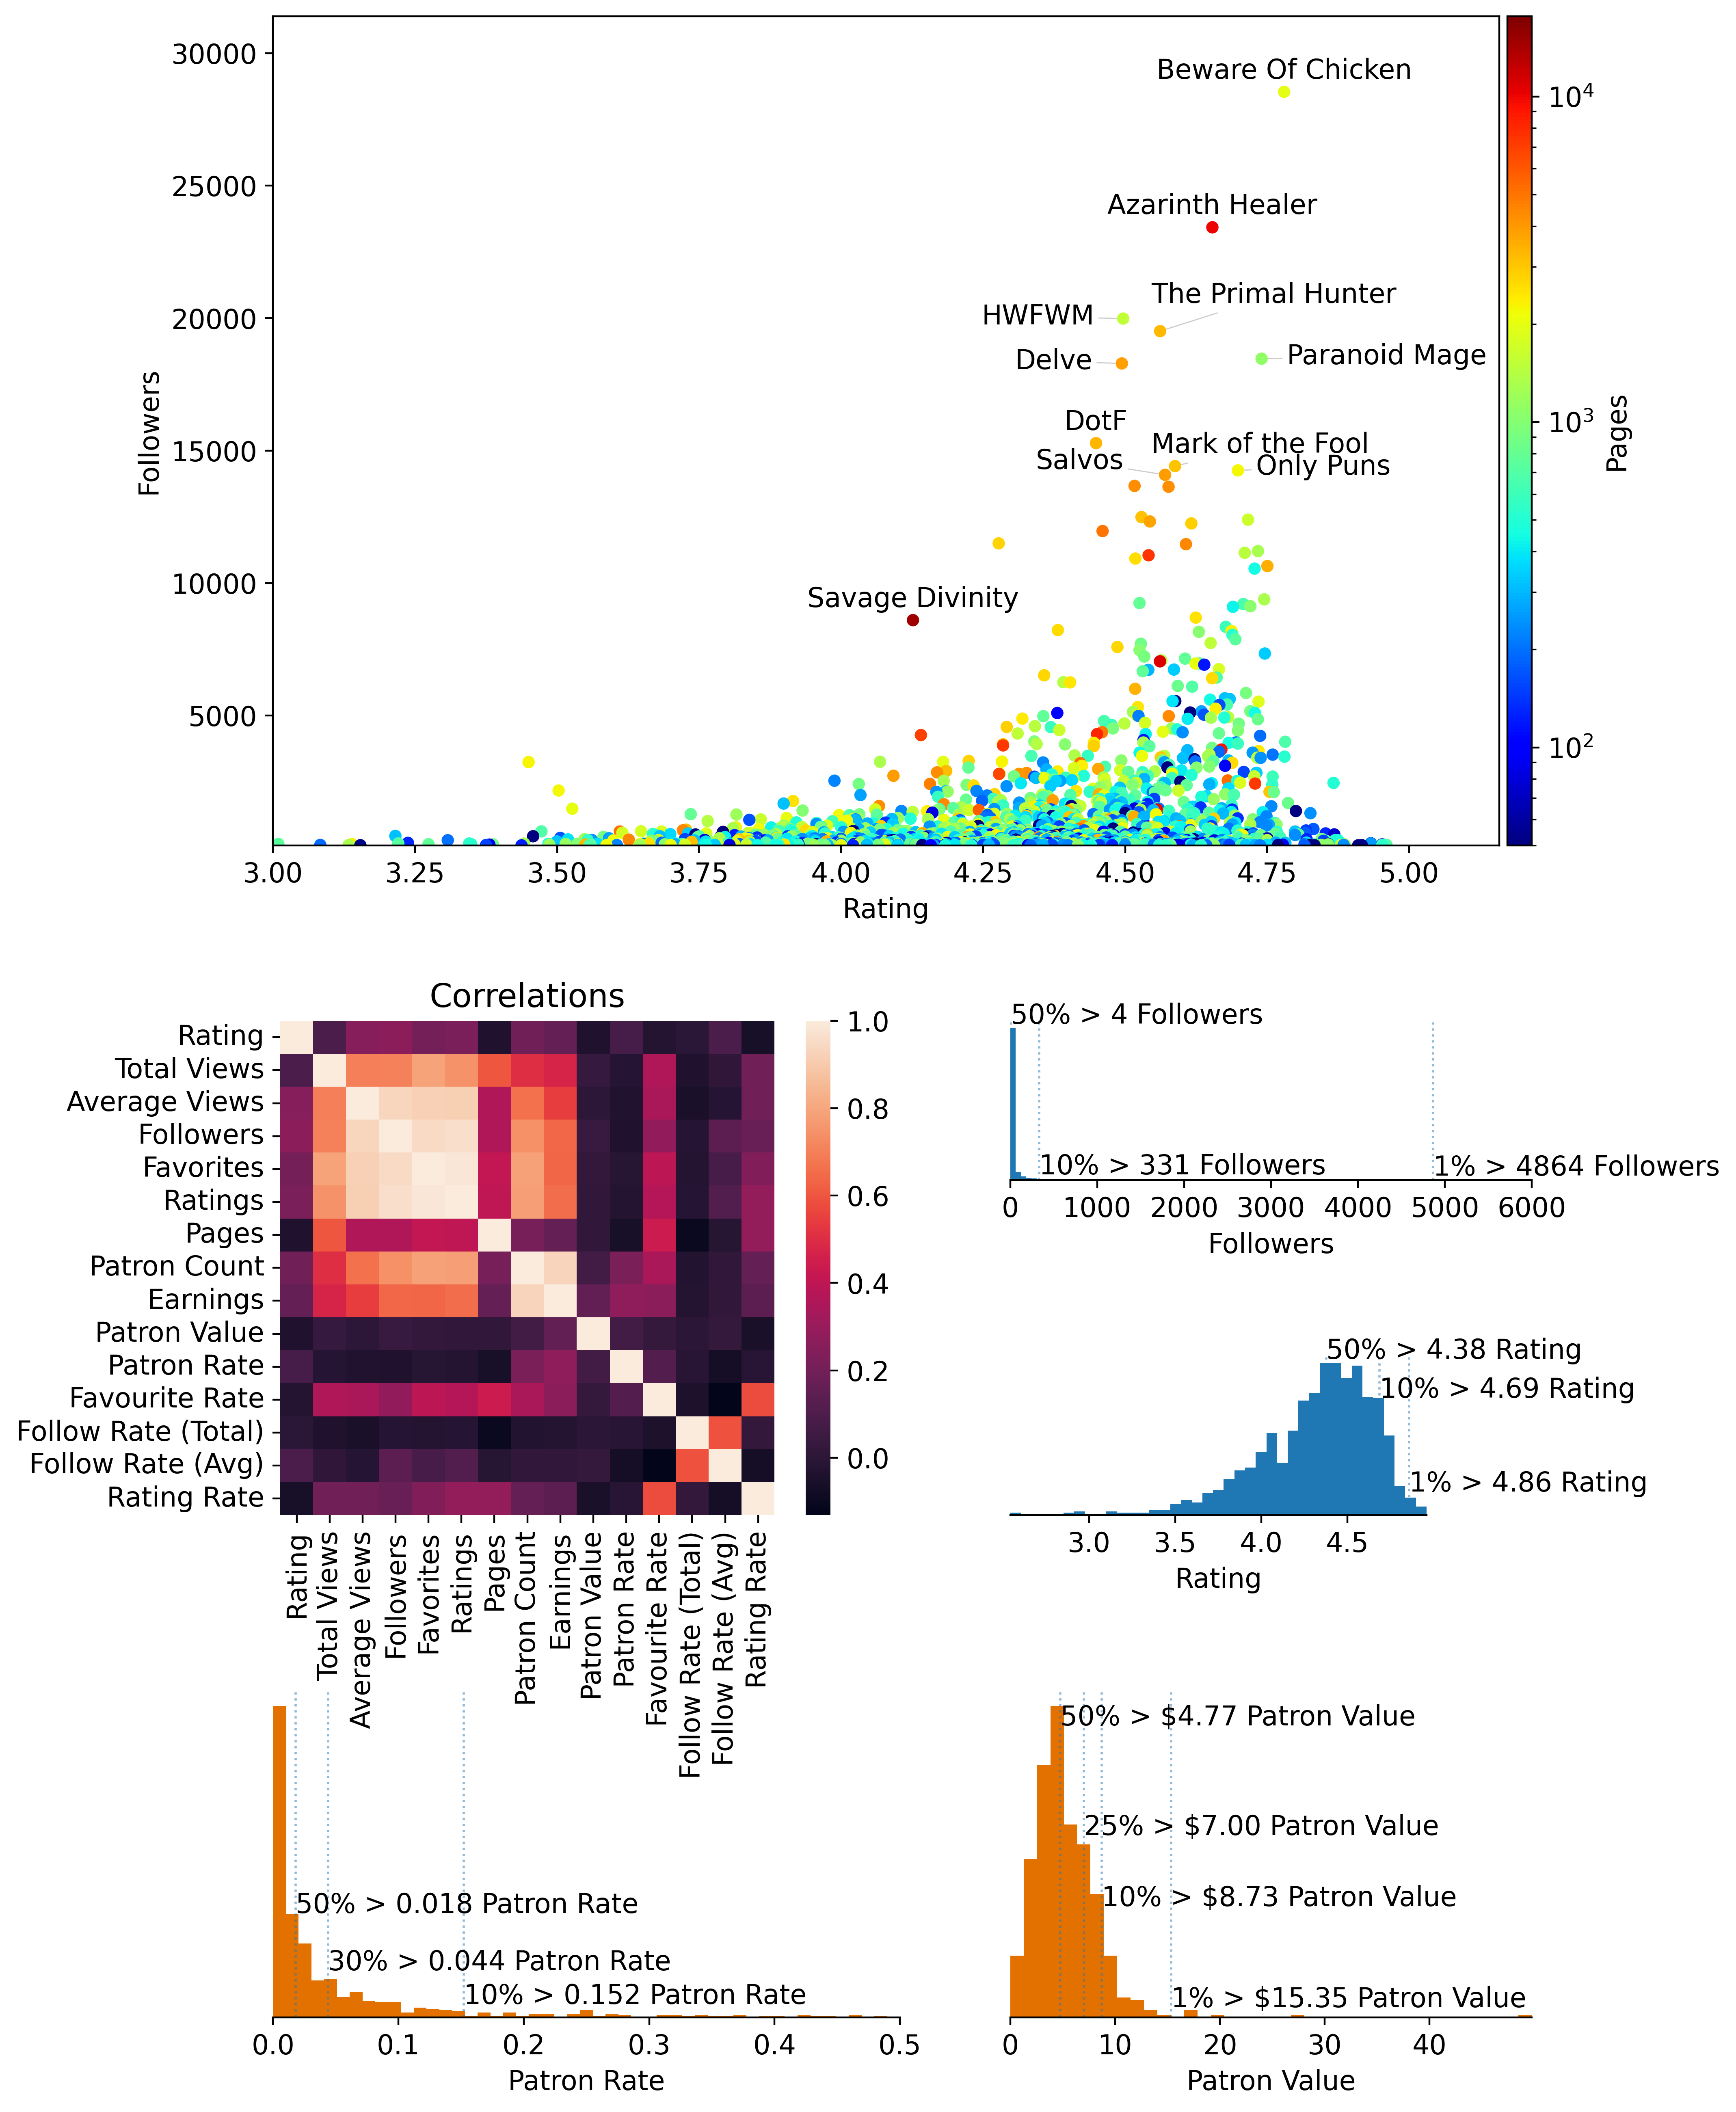

In [76]:
fig = plt.figure(figsize=(10, 16), constrained_layout=True)
gs = fig.add_gridspec(12, 12, wspace=0.05, hspace=0.05)
ax_big = fig.add_subplot(gs[0:5, :])
ax_corr = fig.add_subplot(gs[6:9, :6])

ax_followers = fig.add_subplot(gs[6:7, 7:])
ax_ratings = fig.add_subplot(gs[8:9, 7:11])
ax_patron_rate = fig.add_subplot(gs[10:, :6])
ax_patron_value = fig.add_subplot(gs[10:, 7:])
for ax in [ax_patron_rate]:
    ax.patch.set_alpha(0)
plot_overview(df_established, ax_big, fig)
plot_followers(df, ax_followers)
plot_ratings(df_established, ax_ratings)
plot_prate(df_established, ax_patron_rate)
plot_pvalue(df_established, ax_patron_value)
plot_cor(df_established, ax_corr)

!!! img-poster

Alright, I hate it. Normally when making an inforgraphic I'd get each plot, save it out, and then compose it in Illustrator/Photoshop. Trying to do it all in matplotlib, and without spending more time on it, is incredibly frustrating.

So you know what, let's just run with this unholy abomination. Interesting things we note:

1. Page count nor rating is useful in predicing followers, or income.
2. In general, the more Followers you get, your average rating will be higher. This is probably just the fact you can average out rating bombs if you have enough people.
3. Typically about 30% of Followers will leave a rating.
4. Its hard to get Patreon conversion, 2% is the median, and even the top 10% aren't breaking 20%.
5. However, each conversion represents about 5USD, which is nice.
6. Beware of Chicken is absolutely *crushing* the Follower count.
7. The grind for new stories is horrific. 50% of stories updated in the last 6 months have four followers or less. The top ten percent are only in aruond 300, which isn't enough for a proper readership and career swap. The top 1% get around 5000 followers.
8. If you're above 4.4 stars, you're above average.